In [1]:
import pandas as pd
import numpy as np
from sklearn import datasets, linear_model
import matplotlib.pyplot as plt
import re
import os
import glob
import sys

# Directory where all the experiments are found. 
# Must end with "/" at the end
dir = "/Users/alexe/OM/atests/unit-new-meas-res/res-may06-z17-all-ops-no-quant/"

#arch (used in function names for estimate of exec time)
zarch = "z17"

In [2]:
# Version with curve fitting models to a two variable function and --profile-ir approach
# data generated with script unit-new-meas/commands.sh

# graph: on the y axis it is seconds (because that is what make-report does by default.
# on the x axis for CPU: its the multiplication of each of the dims (for linear/non matmul). For matmul, its the matmul complexity
#    for NNPA, we do a regression and we take the proper ratio between the two metrics we use.

# For matrix multiply.
NNPA_N_CEIL  = 2.0
NNPA_N_CEIL2 = 32.0
NNPA_M_CEIL  = 64.0
NNPA_K_CEIL  = 64.0

# For elemntwise and others.
NNPA_E2_CEIL  = 2.0
NNPA_E2_CEIL2 = 32.0
NNPA_E1_CEIL  = 64.0

def ms_ceiling(n, m):
    return np.ceil(n/m) * m

def filter_complexity(df, dev_name, max_compute, min_mean, min_e1, min_e2):
    # cap of compute at val
    # cap of meas at 1.1us as the resolution of the timers is 1us.
    df_filter = df[(df["opCompute"] < max_compute) & (df["mean"] > min_mean) & (df["e1"]>=min_e1)  & (df["e2"]>=min_e2)] .copy()
    print(dev_name, ": original rows", df.shape[0], ", filtered rows", df_filter.shape[0])
    assert df_filter.shape[0]>0, "filtered too agressively, dev=" + dev_name + ", cap at=" + str(val) 
    return df_filter

def scan_csv(file_name):
    # Has no header, state so.
    df = pd.read_csv(file_name, header=None)
    # print(df.to_string())
    # Give names.
    df.columns =["titleTile", "e3", "e2", "e1", "titleOption", "option", "opName", "invokeNum", "measAverage", "mean", "percent"] 
    # Get rid of titles.
    df1 = df.drop(columns=["titleTile", "titleOption",  "opName",  "measAverage", "percent"])
    #print(df1.to_string())
    return df1

def prepare_cpu_data(df, op_name):
    # Get data for cpu, using "~" to indicate "all but the ones that...". . 
    df_cpu = df[~df["option"].str.contains("-maccel=NNPA")].copy()
    if re.match(r'MatMul', op_name):
        if re.match(r'MatMul2D', op_name):
            print("CPU: Use MatMul 2D compute complexity.")
            # MatMul2D test uses e1-3 in different ways: (N=e3 x M=e2) * (M=e2 x K=e1).
            (N, M, K) = ("e3", "e2", "e1")
            df_cpu["opCompute"] = (df_cpu[N] * df_cpu[M] * df_cpu[K])
        else:
            print("CPU: Use MatMul 3D compute complexity.")
            # MatMul test uses e1-3 in different ways: (B=e3 x N=e2 x M=e1) * (B=e3 x M=e1 x K=e1).
            # Namely the second matrix is square.
            (B, N, M, K) = ("e3", "e2", "e1", "e1")
            # Simply states broadcast B times N * M * K
            df_cpu["opCompute"] = df_cpu[B] * (df_cpu[N] * df_cpu[M] * df_cpu[K])
        code_cpu  = "(double B, double N, double M, double K) {\n"
        code_cpu += "  double complexity = B * (N * M * K);\n"
    else:
        df_cpu["opCompute"] = df_cpu["e3"] * df_cpu["e2"] * df_cpu["e1"]
        code_cpu  = "(double e3, double e2, double e1) {\n"
        code_cpu += "  double complexity = e3 * e2 * e1;\n"
    df_cpu["opTime"] = df_cpu["mean"]
    return (df_cpu, code_cpu)

def prepare_nnpa_data(df, op_name):
    # Get only the data for options with NNPA. 
    # Must add a copy to let Pandas know we want a whole new table, not a view.
    df_nnpa = df[df["option"].str.contains("-maccel=NNPA")].copy()
    if re.match(r'MatMul', op_name):
        if re.match(r'MatMul2D', op_name):
            print("NNPA: Use MatMul 2D compute complexity.")
            # MatMul test uses e1-3 in different ways: (N=e3 x M=e2) * (M=e2 x K=e1).
            (N, M, K) = ("e3", "e2", "e1")
            # not sure the formula below is correct.
            # Cedric's formula is ceil(N/2)*2 * ceil(M/64)*64 * ceil(K/64)*64. Works much better with ceil(N,32)*32.
            df_nnpa["opCompute"]  = ms_ceiling(df_nnpa[N], NNPA_N_CEIL)  * ms_ceiling(df_nnpa[M], NNPA_M_CEIL) * ms_ceiling(df_nnpa[K], NNPA_K_CEIL)
            df_nnpa["opCompute2"] = ms_ceiling(df_nnpa[N], NNPA_N_CEIL2) * ms_ceiling(df_nnpa[M], NNPA_M_CEIL) * ms_ceiling(df_nnpa[K], NNPA_K_CEIL)
        else:
            print("NNPA: Use MatMul 3D compute complexity.")
            # MatMul test uses e1-3 in different ways: (B=e3 x N=e2 x M=e1) * (B=e3 x M=e1 x K=e1).
            (B, N, M, K) = ("e3", "e2", "e1", "e1")
            # Cedric's formula is ceil(N/2)*2 * ceil(M/64)*64 * ceil(K/64)*64. Works much better with ceil(N,32)*32.
            # Simply states broadcast B times Cedric's formula
            df_nnpa["opCompute"]  = df_nnpa[B] * ms_ceiling(df_nnpa[N], NNPA_N_CEIL)  * ms_ceiling(df_nnpa[M], NNPA_M_CEIL) * ms_ceiling(df_nnpa[K], NNPA_K_CEIL)
            df_nnpa["opCompute2"] = df_nnpa[B] * ms_ceiling(df_nnpa[N], NNPA_N_CEIL2) * ms_ceiling(df_nnpa[M], NNPA_M_CEIL) * ms_ceiling(df_nnpa[K], NNPA_K_CEIL)
        code_nnpa =  "(double B, double N, double M, double K) {\n"
        code_nnpa += "  double complexity  = B * ms_ceiling(N, {:.1f}) * ms_ceiling(M, {:.1f}) * ms_ceiling(K, {:.1f});\n".format(NNPA_N_CEIL, NNPA_M_CEIL, NNPA_K_CEIL)
        code_nnpa += "  double complexity2 = B * ms_ceiling(N, {:.1f}) * ms_ceiling(M, {:.1f}) * ms_ceiling(K, {:.1f});\n".format(NNPA_N_CEIL2, NNPA_M_CEIL, NNPA_K_CEIL)
    else:
        df_nnpa["opCompute"]  = df_nnpa["e3"] * ms_ceiling(df_nnpa["e2"], NNPA_E2_CEIL)  * ms_ceiling(df_nnpa["e1"], NNPA_E1_CEIL)
        df_nnpa["opCompute2"] = df_nnpa["e3"] * ms_ceiling(df_nnpa["e2"], NNPA_E2_CEIL2) * ms_ceiling(df_nnpa["e1"], NNPA_E1_CEIL)
        code_nnpa  = "(double e3, double e2, double e1) {\n"
        code_nnpa += "  double complexity  = e3 * ms_ceiling(e2, {:.1f}) * ms_ceiling(e1, {:.1f});\n".format(NNPA_E2_CEIL, NNPA_E1_CEIL)
        code_nnpa += "  double complexity2 = e3 * ms_ceiling(e2, {:.1f}) * ms_ceiling(e1, {:.1f});\n".format(NNPA_E2_CEIL2, NNPA_E1_CEIL)
    df_nnpa["opTime"] = df_nnpa["mean"]
    return (df_nnpa, code_nnpa)

def compute_regr(df, dev_name, op_name, color_name, print_graph=0):
    # Extract vectors for CPU regression, reshaping them as regression expect them to be: [lenCpu, 1].
    if dev_name == "NNPA":
        # Create an x array with one row per data point, and 2 columns, one for each complexity metric.
        x = np.vstack((df.opCompute.values, df.opCompute2.values)).T
    else:
        # create an x array with one row per data point and one column for the single complexity metric
        x = df.opCompute.values.reshape(-1, 1)
    y = df.opTime.values.reshape(-1, 1)
    #print(x, y)
    # Compute CPU Regression. See https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
    regr = linear_model.LinearRegression()
    regr.fit(x, y)
    r2 = regr.score(x, y)
    # Compute a scatter friendly single dimension x for scatter analysis
    if dev_name == "NNPA":
        b = regr.coef_[0][0]
        c = regr.coef_[0][1]
        # 2D regression is f(x, y) = a + bx + cy
        # Now projecting (x, y) -> (z) where z = (bx + cy)/(b+c) 
        #   we get g(z) = a + (b + c)z  and by substituting z by its def above, we get
        #   g(z) = a + bx + cy 
        x_scatter = df.opCompute.values * b / (b+c) + df.opCompute2.values * c / (b+c)
    else:
        x_scatter = x

    print(dev_name, ": regression coef, ", regr.coef_, ", intercept", regr.intercept_, ", r2, ", r2)
    if print_graph >= 2:
        # Plot CPU regression
        plt.scatter(x_scatter, y,  color='black')
        plt.plot(x_scatter, regr.predict(x), color=color_name, linewidth=3)
        plt.title(op_name + " on " + dev_name + " with r2 " + str(r2))
        plt.show()
    if print_graph >= 3:
        df["opPredict"] = regr.predict(x)
        df["opErrorRatio"] = df["opPredict"] / df["opTime"]
        cutoff = 0.15
        df_predict_too_small = df[df["opErrorRatio"] < (1.0 - cutoff)].copy()
        predict_too_small_num = df_predict_too_small.shape[0]
        df_predict_too_big = df[df["opErrorRatio"] > (1.0 + cutoff)].copy()
        predict_too_big_num = df_predict_too_big.shape[0]
        print("Error for op", op_name, "and dev", dev_name);
        print("Measurement smaller than prediciton for", predict_too_big_num, "data points:\n")
        if predict_too_big_num > 0:
            print(df_predict_too_big.to_string(), "\n")
        print("Measurement larger than prediciton for", predict_too_small_num, "data points:\n")
        if predict_too_small_num > 0:
            print(df_predict_too_small.to_string(), "\n")
    return (regr, x, x_scatter, y, r2)

def print_cross_over_graph(op_name, regr_cpu, x_cpu, y_cpu, regr_nnpa, x_nnpa, x_scatter_nnpa, y_nnpa, print_graph):
    plt.plot(x_cpu, regr_cpu.predict(x_cpu), color='blue', linewidth=1, label="CPU")
    plt.plot(x_scatter_nnpa, regr_nnpa.predict(x_nnpa), color='red', linewidth=1, label="NNPA")
    if print_graph>=2:
        plt.scatter(x_cpu, y_cpu, color='blue')
        plt.scatter(x_scatter_nnpa, y_nnpa, color='red')
    plt.legend()
    plt.title(op_name)
    plt.show()

def gen_cpu_code(op_name, regr_cpu, code_cpu, r2_cpu):
    c_op_name = op_name.replace("-", "_")
    code = "// Operation " + c_op_name + ": estimated times.\n"
    code +=  "double estimatedTimeForCPU_" + c_op_name + "_" + zarch + code_cpu 
    code += "  // Regression for CPU with r2 = " + str(r2_cpu) + "\n"
    code += "  return " + str(regr_cpu.intercept_[0]) + " + " + str(regr_cpu.coef_[0][0]) + " * complexity;\n"
    code += "}\n"
    return code;

def gen_nnpa_code(op_name, regr_nnpa, code_nnpa, r2_nnpa):
    c_op_name = op_name.replace("-", "_")
    code = "// Operation " + c_op_name + ": estimated times.\n"
    code +=  "double estimatedTimeForNNPA_" + c_op_name + "_" + zarch + code_nnpa 
    code += "  // Regression for NNPA with r2 = " + str(r2_nnpa) + "\n"
    code += "  return " + str(regr_nnpa.intercept_[0]) + " + " + str(regr_nnpa.coef_[0][0]) + " * complexity +" + str(regr_nnpa.coef_[0][1]) + " * complexity2;\n"
    code += "}\n"
    return code;

def get_file_name_possibly_prefix(file_name):
    if os.path.exists(file_name):
        return file_name
    files = glob.glob(file_name + "*.csv")
    if len(files) == 0:
        print("could not find any files with prefix", file_name, "abort")
        sys.exit(1)
    if len(files) > 1:
        print("WARNING, got more than one file with prefix", file_name, "keep first one")
    print("used name as prefix to load this input file", files[0])
    return files[0]

#########################################################################################################
# Main entry point
# Scan file, filter, compute regression and generate code.
#########################################################################################################

def compute_reg(op_name, file_name, max_compute=1e6, min_mean=1.1e-6, min_e1=1, min_e2=32, print_graph=2):
    file_name = get_file_name_possibly_prefix(file_name)
    df = scan_csv(file_name)
    # Compute regression for CPU.
    (df_cpu_full, code_cpu) = prepare_cpu_data(df, op_name)
    has_cpu = df_cpu_full.shape[0] > 0
    code = ""
    if has_cpu:
        df_cpu = filter_complexity(df_cpu_full, "CPU", max_compute, min_mean, min_e1, min_e2)
        (regr_cpu, x_cpu, x_scatter_cpu, y_cpu, r2_cpu) = compute_regr(df_cpu, "CPU", op_name, "blue", print_graph)
        code += gen_cpu_code(op_name, regr_cpu, code_cpu, r2_cpu)
    # Compute regression for NNPA
    (df_nnpa_full, code_nnpa) = prepare_nnpa_data(df, op_name)
    has_nnpa = df_nnpa_full.shape[0] > 0
    if has_nnpa:
        df_nnpa = filter_complexity(df_nnpa_full, "NNPA", max_compute, min_mean, min_e1, min_e2)
        (regr_nnpa, x_nnpa, x_scatter_nnpa, y_nnpa, r2_nnpa) = compute_regr(df_nnpa, "NNPA", op_name, "red", print_graph)
        code += gen_nnpa_code(op_name, regr_nnpa, code_nnpa, r2_nnpa)
    if print_graph>=1 and has_cpu and has_nnpa:
        print_cross_over_graph(op_name, regr_cpu, x_cpu, y_cpu, regr_nnpa, x_nnpa, x_scatter_nnpa, y_nnpa, print_graph)
    if print_graph>=2:
        print(code);
    if has_cpu and has_nnpa:
        return {"cpu": regr_cpu, "nnpa": regr_nnpa, "code": code, "r2_cpu": r2_cpu, "r2_nnpa": r2_nnpa}
    if has_cpu:
        return {"cpu": regr_cpu, "code": code, "r2_cpu": r2_cpu}
    if has_nnpa:
        return {"nnpa": regr_nnpa, "code": code, "r2_nnpa": r2_nnpa}
    return {}


# Additional support.
def plot_regressions(db, list_of_op_dev, graph_title=""):
    x = [[0], [800000]]
    for tuple in list_of_op_dev:
        (op, dev) = tuple
        regr = db[op][dev]
        r2 = db[op]["r2_"+dev]
        label_name = op+"_"+dev+"_r2={:.2f}".format(r2)
        if dev=="nnpa":
            plt.plot(x, regr.predict(x), linewidth=1, linestyle='dashed', label=label_name)
        else:
            plt.plot(x, regr.predict(x), linewidth=1, label=label_name)            
    plt.legend()
    plt.title(graph_title)
    plt.show()

def eval_with_regr(db, op, sizes):
    if re.match(r'MatMul', op):
        (B, N, M, K) = sizes
        complexity_cpu = B * N * M * K
        complexity_nnpa = B * ms_ceiling(N, NNPA_N_CEIL) * ms_ceiling(M, NNPA_M_CEIL) * ms_ceiling(K, NNPA_K_CEIL)
    else:
        (e3, e2, e1) = sizes
        complexity_cpu = e3 * e2 * e1
        complexity_nnpa = B * ms_ceiling(e2, NNPA_E2_CEIL) * ms_ceiling(e1, NNPA_E1_CEIL)
    (x_cpu,  c_cpu)  = (db[op]["cpu"].coef_[0][0],  db[op]["cpu"].intercept_[0])
    (x_nnpa, c_nnpa) = (db[op]["nnpa"].coef_[0][0], db[op]["nnpa"].intercept_[0])
    time_cpu  = x_cpu  * complexity_cpu +  c_cpu
    time_nnpa = x_nnpa * complexity_nnpa +  c_nnpa
    print("Analysis for sizes", sizes)
    print("  CPU:  complexity " + str(complexity_cpu))
    print("  NNPA: complexity "+ str(complexity_nnpa))
    print("  CPU   time       " + str(time_cpu)  + " (" + str(x_cpu)  + ", " + str(c_cpu))
    print("  NNPA  time       " + str(time_nnpa) + " (" + str(x_nnpa) + ", " + str(c_nnpa))
    if (time_nnpa < time_cpu):
        print("  NNPA is faster")
    else:
        print("  CPU is faster")



CPU == NNPA dlfloat (no quantization), NNPA == NNPA int8 (int8 asym input, symetrical weight quantizaton)


used name as prefix to load this input file /Users/alexe/OM/atests/unit-new-meas-res/res-may06-z17-all-ops-no-quant/test_matmul1_dlfloat16_int8_asym_sym_2025-05-14-10-24-26.csv
CPU: Use MatMul 2D compute complexity.
CPU : original rows 343 , filtered rows 343
CPU : regression coef,  [[1.73775759e-12]] , intercept [0.00082985] , r2,  0.6083076995715989


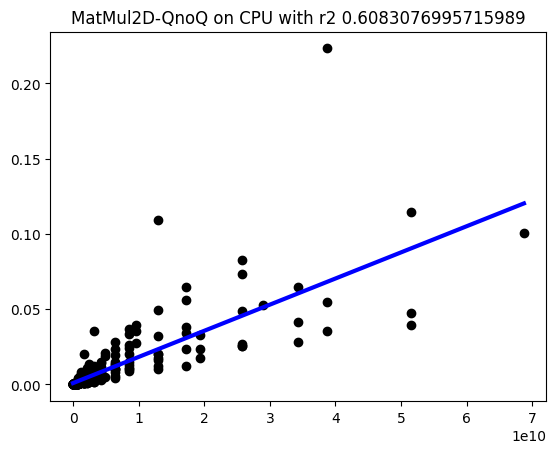

NNPA: Use MatMul 2D compute complexity.
NNPA : original rows 343 , filtered rows 343
NNPA : regression coef,  [[ 6.97254828 -6.97254828]] , intercept [0.00220471] , r2,  0.5551888461432367


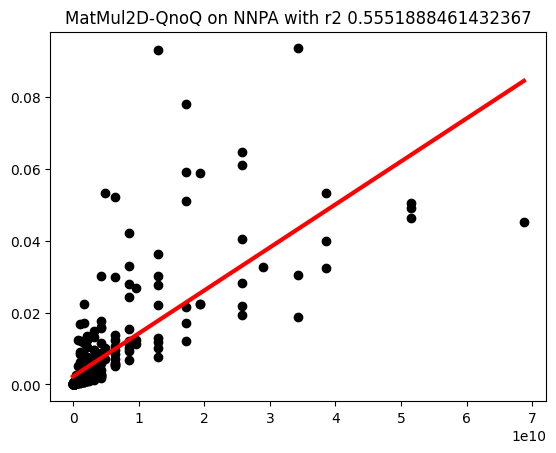

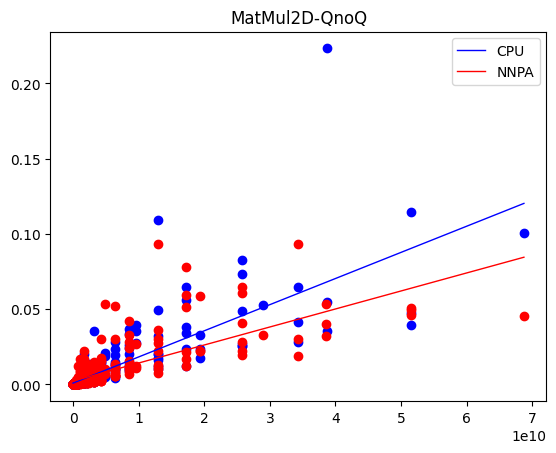

// Operation MatMul2D_QnoQ: estimated times.
double estimatedTimeForCPU_MatMul2D_QnoQ_z17(double B, double N, double M, double K) {
  double complexity = B * (N * M * K);
  // Regression for CPU with r2 = 0.6083076995715989
  return 0.000829854644376308 + 1.7377575940828635e-12 * complexity;
}
// Operation MatMul2D_QnoQ: estimated times.
double estimatedTimeForNNPA_MatMul2D_QnoQ_z17(double B, double N, double M, double K) {
  double complexity  = B * ms_ceiling(N, 2.0) * ms_ceiling(M, 64.0) * ms_ceiling(K, 64.0);
  double complexity2 = B * ms_ceiling(N, 32.0) * ms_ceiling(M, 64.0) * ms_ceiling(K, 64.0);
  // Regression for NNPA with r2 = 0.5551888461432367
  return 0.0022047091256134875 + 6.972548278787515 * complexity +-6.972548278786317 * complexity2;
}



CPU == NNPA dlfloat (no quantization), NNPA == NNPA int8 (int8 asym input, symetrical weight quantizaton)




In [ ]:
regdb = {}
msg = "\n\nCPU == NNPA dlfloat (no quantization), NNPA == NNPA int8 (int8 asym input, symetrical weight quantizaton)\n\n"
print(msg)
# Technically, there is a problem to because the CPU uses the actual numbers of complexity, but NNPA use ceil 2 & 32. But since the experiments only uses power of 2, its ok.
regdb["MatMul2D-QnoQ"] = compute_reg("MatMul2D-QnoQ", dir+"test_matmul_dlfloat16_int8_asym_sym_", max_compute=1e12)
print(msg)

used name as prefix to load this input file /Users/alexe/OM/atests/unit-new-meas-res/res-may06-z17-all-ops-no-quant/test_add1_2025-05-05-22-26-59.csv
CPU : original rows 132 , filtered rows 38
CPU : regression coef,  [[9.43613348e-11]] , intercept [1.04145976e-06] , r2,  0.9794305300045331


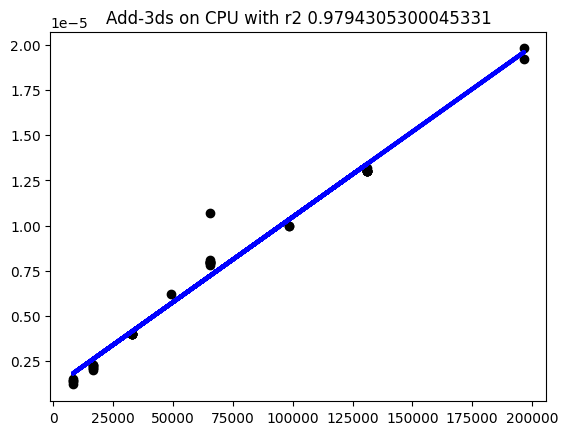

NNPA : original rows 132 , filtered rows 43
NNPA : regression coef,  [[1.9088979e-11 1.9088979e-11]] , intercept [1.8567493e-06] , r2,  0.9697580789334318


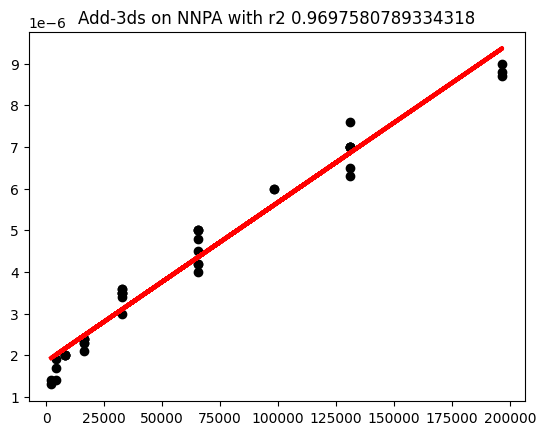

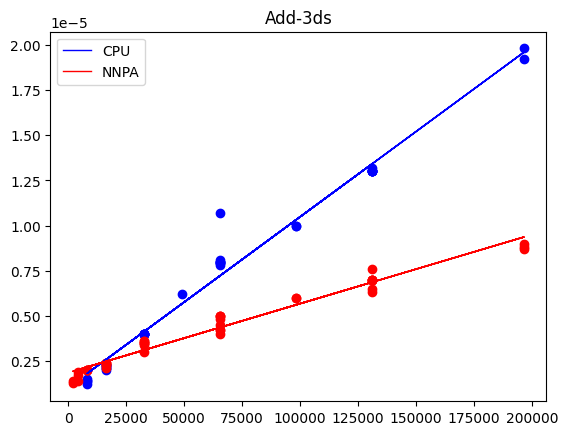

// Operation Add_3ds: estimated times.
double estimatedTimeForCPU_Add_3ds_z17(double e3, double e2, double e1) {
  double complexity = e3 * e2 * e1;
  // Regression for CPU with r2 = 0.9794305300045331
  return 1.0414597616987286e-06 + 9.436133475545827e-11 * complexity;
}
// Operation Add_3ds: estimated times.
double estimatedTimeForNNPA_Add_3ds_z17(double e3, double e2, double e1) {
  double complexity  = e3 * ms_ceiling(e2, 2.0) * ms_ceiling(e1, 64.0);
  double complexity2 = e3 * ms_ceiling(e2, 32.0) * ms_ceiling(e1, 64.0);
  // Regression for NNPA with r2 = 0.9697580789334318
  return 1.8567493018624777e-06 + 1.9088979028012123e-11 * complexity +1.9088979028012123e-11 * complexity2;
}



In [ ]:
regdb["Add-3ds"] = compute_reg("Add-3ds", dir+"test_add_", max_compute=2e5, print_graph=2)

used name as prefix to load this input file /Users/alexe/OM/atests/unit-new-meas-res/res-may06-z17-all-ops-no-quant/test_sub1_2025-05-05-22-28-40.csv
CPU : original rows 132 , filtered rows 56
CPU : regression coef,  [[9.55254518e-11]] , intercept [8.53949178e-07] , r2,  0.9994300646660222


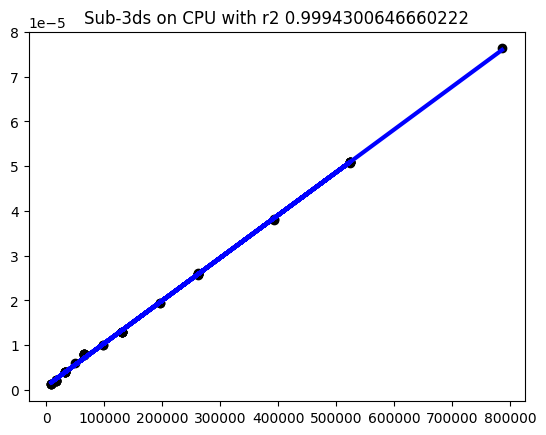

NNPA : original rows 132 , filtered rows 62
NNPA : regression coef,  [[1.7232617e-11 1.7232617e-11]] , intercept [2.3492432e-06] , r2,  0.9953310347130198


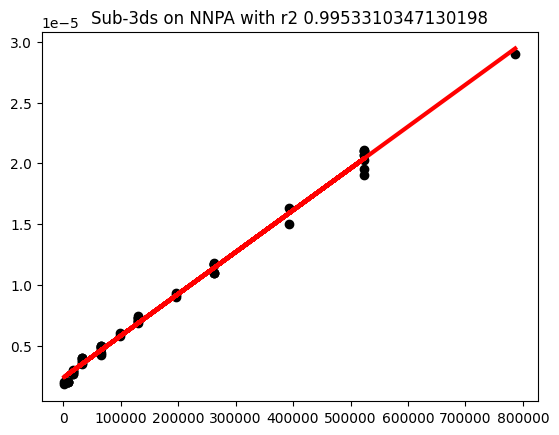

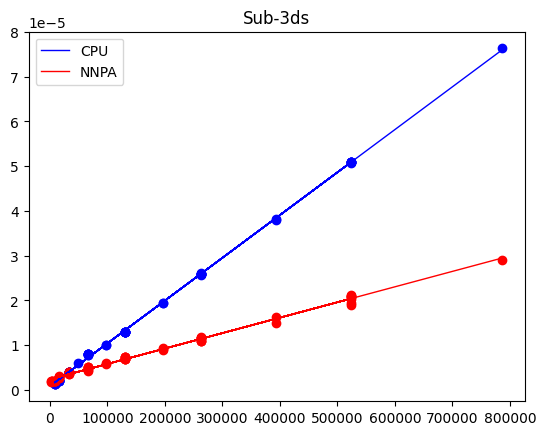

// Operation Sub_3ds: estimated times.
double estimatedTimeForCPU_Sub_3ds_z17(double e3, double e2, double e1) {
  double complexity = e3 * e2 * e1;
  // Regression for CPU with r2 = 0.9994300646660222
  return 8.53949178130232e-07 + 9.552545176353334e-11 * complexity;
}
// Operation Sub_3ds: estimated times.
double estimatedTimeForNNPA_Sub_3ds_z17(double e3, double e2, double e1) {
  double complexity  = e3 * ms_ceiling(e2, 2.0) * ms_ceiling(e1, 64.0);
  double complexity2 = e3 * ms_ceiling(e2, 32.0) * ms_ceiling(e1, 64.0);
  // Regression for NNPA with r2 = 0.9953310347130198
  return 2.3492432002936522e-06 + 1.723261703570422e-11 * complexity +1.723261703570422e-11 * complexity2;
}



In [ ]:
regdb["Sub-3ds"] = compute_reg("Sub-3ds", dir+"test_sub_")

used name as prefix to load this input file /Users/alexe/OM/atests/unit-new-meas-res/res-may06-z17-all-ops-no-quant/test_div1_2025-05-05-22-32-06.csv
CPU : original rows 132 , filtered rows 45
CPU : regression coef,  [[1.36463111e-09]] , intercept [5.786939e-07] , r2,  0.9998048175945131


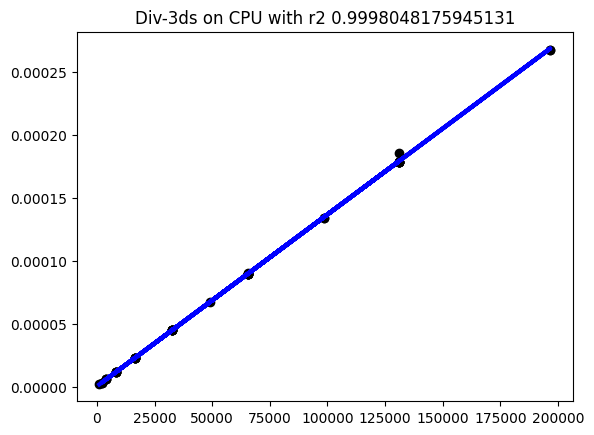

NNPA : original rows 132 , filtered rows 43
NNPA : regression coef,  [[2.94293547e-11 2.94293547e-11]] , intercept [1.98034971e-06] , r2,  0.990816705245199


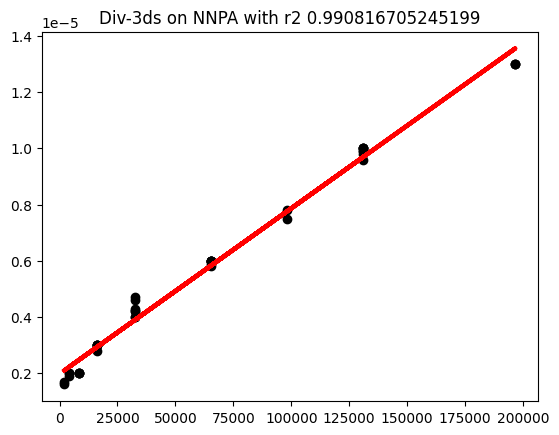

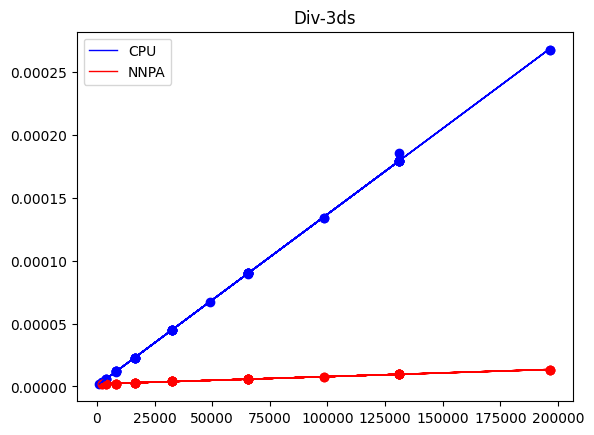

// Operation Div_3ds: estimated times.
double estimatedTimeForCPU_Div_3ds_z17(double e3, double e2, double e1) {
  double complexity = e3 * e2 * e1;
  // Regression for CPU with r2 = 0.9998048175945131
  return 5.786938996660593e-07 + 1.3646311059272094e-09 * complexity;
}
// Operation Div_3ds: estimated times.
double estimatedTimeForNNPA_Div_3ds_z17(double e3, double e2, double e1) {
  double complexity  = e3 * ms_ceiling(e2, 2.0) * ms_ceiling(e1, 64.0);
  double complexity2 = e3 * ms_ceiling(e2, 32.0) * ms_ceiling(e1, 64.0);
  // Regression for NNPA with r2 = 0.990816705245199
  return 1.980349705611261e-06 + 2.942935466811418e-11 * complexity +2.942935466811418e-11 * complexity2;
}



In [ ]:
regdb["Div-3ds"] = compute_reg("Div-3ds", dir+"test_div_", max_compute=2e5, print_graph=2)

used name as prefix to load this input file /Users/alexe/OM/atests/unit-new-meas-res/res-may06-z17-all-ops-no-quant/test_min1_2025-05-05-22-35-39.csv
CPU : original rows 132 , filtered rows 55
CPU : regression coef,  [[9.64185394e-11]] , intercept [8.11971713e-07] , r2,  0.9993518712923539


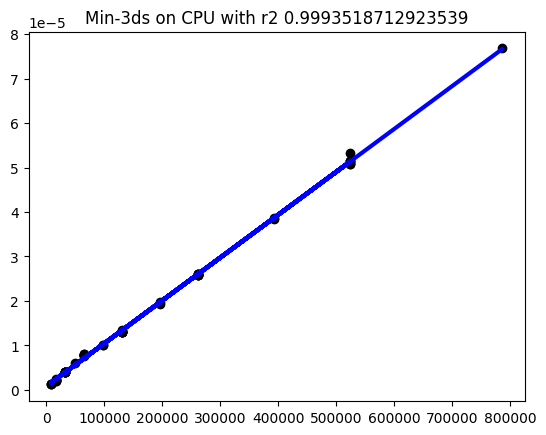

NNPA : original rows 132 , filtered rows 62
NNPA : regression coef,  [[1.74879256e-11 1.74879256e-11]] , intercept [2.04581141e-06] , r2,  0.9948689360722767


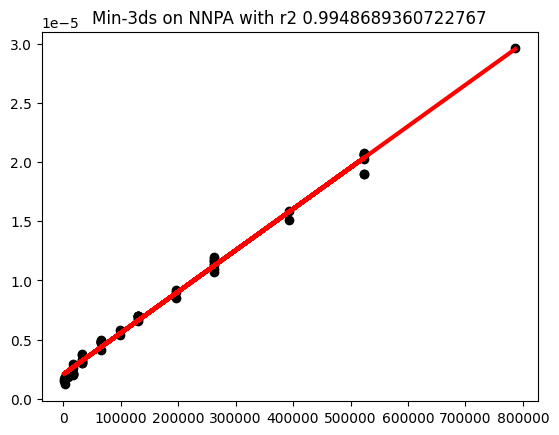

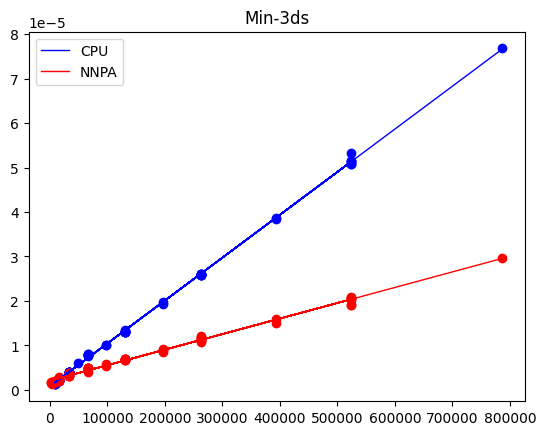

// Operation Min_3ds: estimated times.
double estimatedTimeForCPU_Min_3ds_z17(double e3, double e2, double e1) {
  double complexity = e3 * e2 * e1;
  // Regression for CPU with r2 = 0.9993518712923539
  return 8.119717132969606e-07 + 9.641853939778113e-11 * complexity;
}
// Operation Min_3ds: estimated times.
double estimatedTimeForNNPA_Min_3ds_z17(double e3, double e2, double e1) {
  double complexity  = e3 * ms_ceiling(e2, 2.0) * ms_ceiling(e1, 64.0);
  double complexity2 = e3 * ms_ceiling(e2, 32.0) * ms_ceiling(e1, 64.0);
  // Regression for NNPA with r2 = 0.9948689360722767
  return 2.045811408687477e-06 + 1.7487925635849375e-11 * complexity +1.7487925635849372e-11 * complexity2;
}



In [ ]:
regdb["Min-3ds"] = compute_reg("Min-3ds", dir+"test_min_")

used name as prefix to load this input file /Users/alexe/OM/atests/unit-new-meas-res/res-may06-z17-all-ops-no-quant/test_max1_2025-05-05-22-33-57.csv
CPU : original rows 132 , filtered rows 55
CPU : regression coef,  [[9.59661182e-11]] , intercept [8.55259663e-07] , r2,  0.9996046252770894


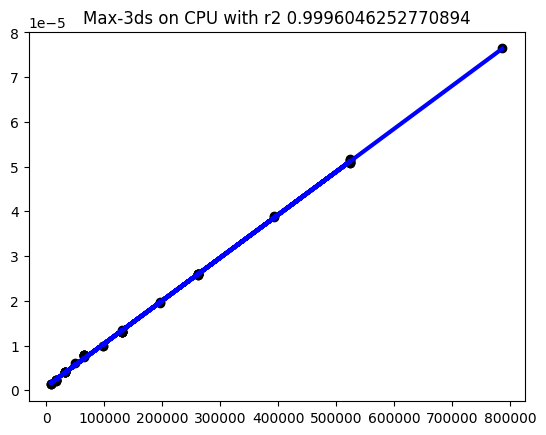

NNPA : original rows 132 , filtered rows 62
NNPA : regression coef,  [[1.73190247e-11 1.73190247e-11]] , intercept [2.07614773e-06] , r2,  0.9926138482906947


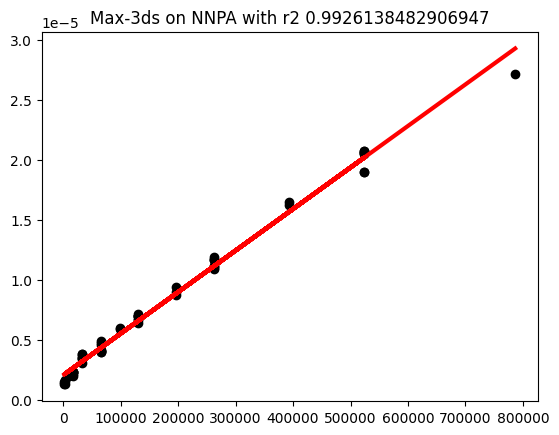

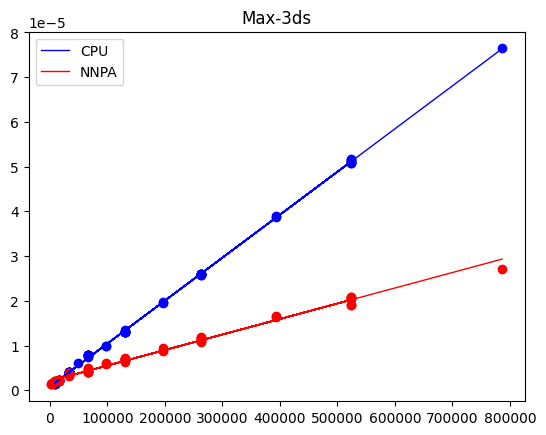

// Operation Max_3ds: estimated times.
double estimatedTimeForCPU_Max_3ds_z17(double e3, double e2, double e1) {
  double complexity = e3 * e2 * e1;
  // Regression for CPU with r2 = 0.9996046252770894
  return 8.55259663295163e-07 + 9.596611822047999e-11 * complexity;
}
// Operation Max_3ds: estimated times.
double estimatedTimeForNNPA_Max_3ds_z17(double e3, double e2, double e1) {
  double complexity  = e3 * ms_ceiling(e2, 2.0) * ms_ceiling(e1, 64.0);
  double complexity2 = e3 * ms_ceiling(e2, 32.0) * ms_ceiling(e1, 64.0);
  // Regression for NNPA with r2 = 0.9926138482906947
  return 2.0761477329513936e-06 + 1.7319024656175555e-11 * complexity +1.7319024656175552e-11 * complexity2;
}



In [ ]:
regdb["Max-3ds"] = compute_reg("Max-3ds", dir+"test_max_")

used name as prefix to load this input file /Users/alexe/OM/atests/unit-new-meas-res/res-may06-z17-all-ops-no-quant/test_mul1_2025-05-05-22-30-22.csv
CPU : original rows 132 , filtered rows 55
CPU : regression coef,  [[9.5730755e-11]] , intercept [8.57642706e-07] , r2,  0.9994096986852347


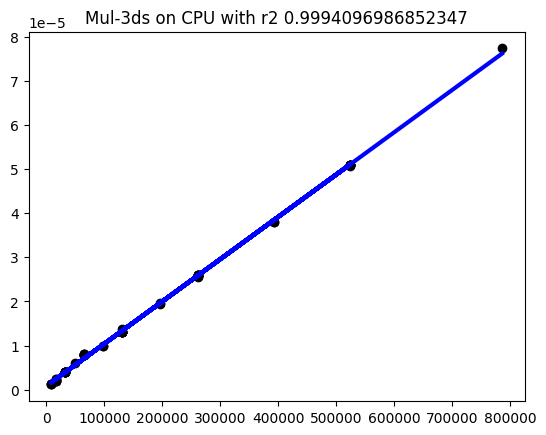

NNPA : original rows 132 , filtered rows 62
NNPA : regression coef,  [[1.7134303e-11 1.7134303e-11]] , intercept [2.12157134e-06] , r2,  0.9938418209740545


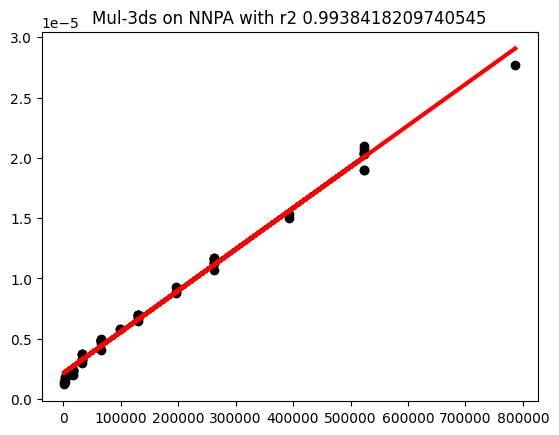

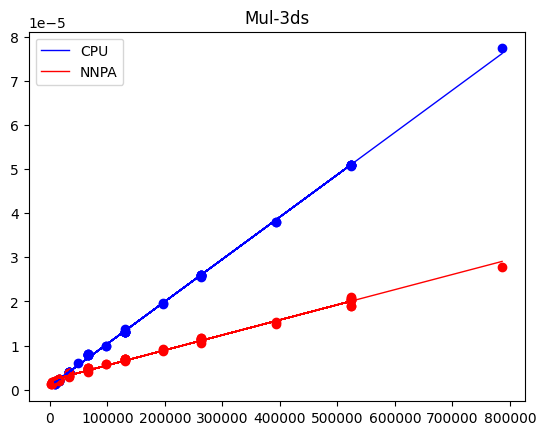

// Operation Mul_3ds: estimated times.
double estimatedTimeForCPU_Mul_3ds_z17(double e3, double e2, double e1) {
  double complexity = e3 * e2 * e1;
  // Regression for CPU with r2 = 0.9994096986852347
  return 8.576427061854475e-07 + 9.573075501041591e-11 * complexity;
}
// Operation Mul_3ds: estimated times.
double estimatedTimeForNNPA_Mul_3ds_z17(double e3, double e2, double e1) {
  double complexity  = e3 * ms_ceiling(e2, 2.0) * ms_ceiling(e1, 64.0);
  double complexity2 = e3 * ms_ceiling(e2, 32.0) * ms_ceiling(e1, 64.0);
  // Regression for NNPA with r2 = 0.9938418209740545
  return 2.1215713448441153e-06 + 1.713430303227113e-11 * complexity +1.713430303227113e-11 * complexity2;
}



In [ ]:
regdb["Mul-3ds"] = compute_reg("Mul-3ds", dir+"test_mul_")

used name as prefix to load this input file /Users/alexe/OM/atests/unit-new-meas-res/res-may06-z17-all-ops-no-quant/test_pow1-2_2025-05-05-23-11-04.csv
CPU : original rows 132 , filtered rows 56
CPU : regression coef,  [[1.23420226e-10]] , intercept [-8.21085331e-07] , r2,  0.9330727047521541


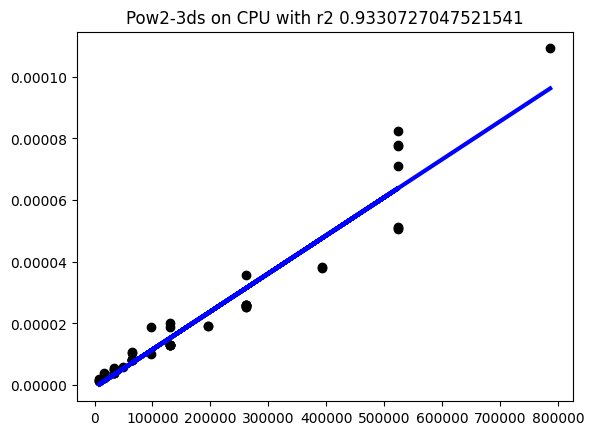

NNPA : original rows 132 , filtered rows 61
NNPA : regression coef,  [[1.89849002e-11 1.89849002e-11]] , intercept [2.16526012e-06] , r2,  0.9903205087066541


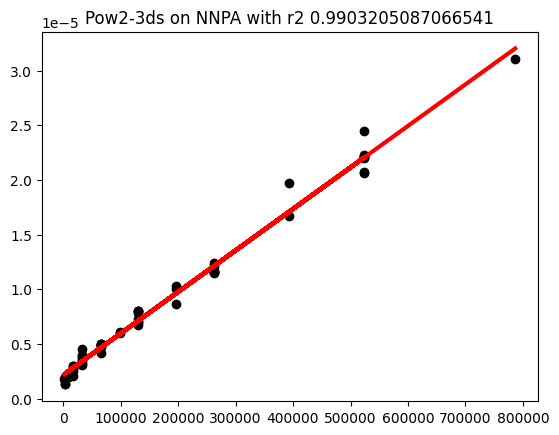

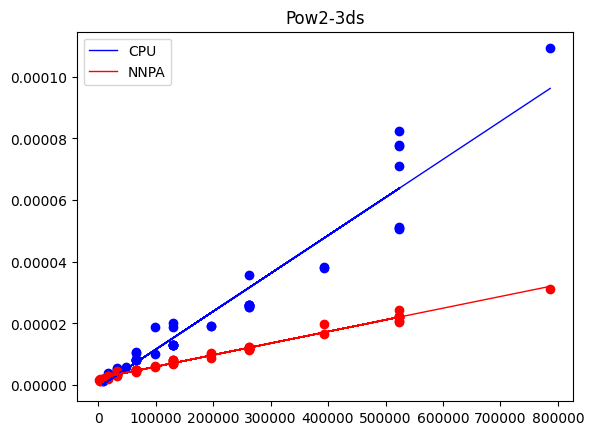

// Operation Pow2_3ds: estimated times.
double estimatedTimeForCPU_Pow2_3ds_z17(double e3, double e2, double e1) {
  double complexity = e3 * e2 * e1;
  // Regression for CPU with r2 = 0.9330727047521541
  return -8.210853307002942e-07 + 1.234202263969703e-10 * complexity;
}
// Operation Pow2_3ds: estimated times.
double estimatedTimeForNNPA_Pow2_3ds_z17(double e3, double e2, double e1) {
  double complexity  = e3 * ms_ceiling(e2, 2.0) * ms_ceiling(e1, 64.0);
  double complexity2 = e3 * ms_ceiling(e2, 32.0) * ms_ceiling(e1, 64.0);
  // Regression for NNPA with r2 = 0.9903205087066541
  return 2.1652601219576765e-06 + 1.898490020005764e-11 * complexity +1.898490020005764e-11 * complexity2;
}



In [ ]:
# pow2 is the same as mul in our experiments
regdb["Pow2-3ds"] = compute_reg("Pow2-3ds", dir+"test_pow-2_")

used name as prefix to load this input file /Users/alexe/OM/atests/unit-new-meas-res/res-may06-z17-all-ops-no-quant/test_pow1-3_2025-05-05-23-13-37.csv
CPU : original rows 132 , filtered rows 63
CPU : regression coef,  [[2.60470778e-10]] , intercept [3.3263848e-06] , r2,  0.947704531709904


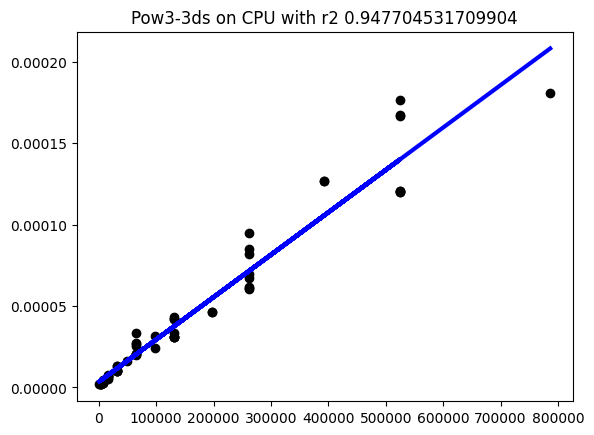

NNPA : original rows 132 , filtered rows 62
NNPA : regression coef,  [[3.54674592e-11 3.54674592e-11]] , intercept [4.06061431e-06] , r2,  0.9939780628358914


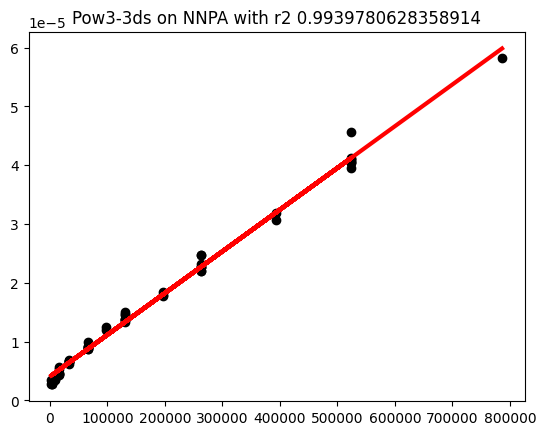

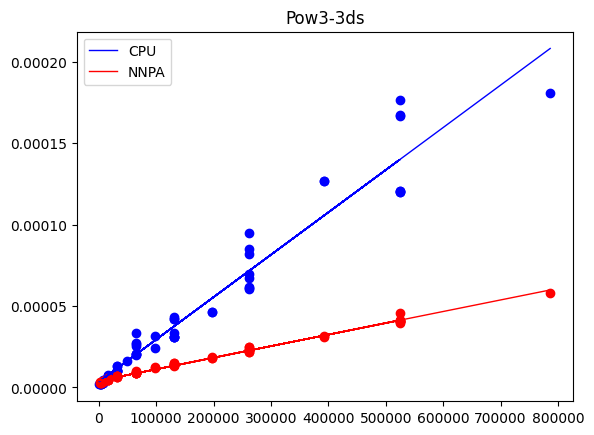

// Operation Pow3_3ds: estimated times.
double estimatedTimeForCPU_Pow3_3ds_z17(double e3, double e2, double e1) {
  double complexity = e3 * e2 * e1;
  // Regression for CPU with r2 = 0.947704531709904
  return 3.3263848039024823e-06 + 2.604707783272701e-10 * complexity;
}
// Operation Pow3_3ds: estimated times.
double estimatedTimeForNNPA_Pow3_3ds_z17(double e3, double e2, double e1) {
  double complexity  = e3 * ms_ceiling(e2, 2.0) * ms_ceiling(e1, 64.0);
  double complexity2 = e3 * ms_ceiling(e2, 32.0) * ms_ceiling(e1, 64.0);
  // Regression for NNPA with r2 = 0.9939780628358914
  return 4.060614306209132e-06 + 3.5467459159039026e-11 * complexity +3.546745915903902e-11 * complexity2;
}



In [ ]:
regdb["Pow3-3ds"] = compute_reg("Pow3-3ds", dir+"test_pow-3_")

used name as prefix to load this input file /Users/alexe/OM/atests/unit-new-meas-res/res-may06-z17-all-ops-no-quant/test_pow1-4_2025-05-05-23-16-02.csv
CPU : original rows 132 , filtered rows 62
CPU : regression coef,  [[2.03728879e-10]] , intercept [6.75279316e-07] , r2,  0.979306482228355


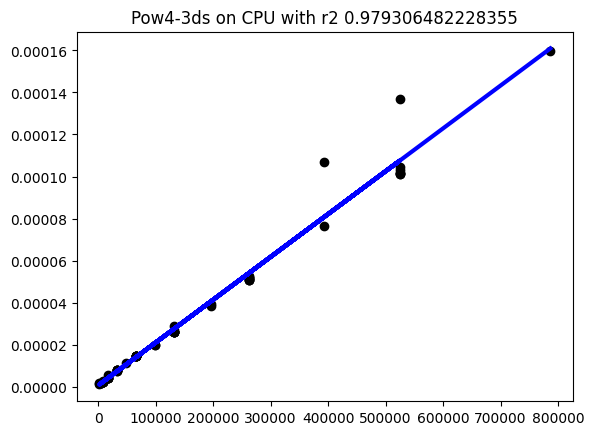

NNPA : original rows 132 , filtered rows 62
NNPA : regression coef,  [[3.43864808e-11 3.43864808e-11]] , intercept [4.26896447e-06] , r2,  0.9931689983532582


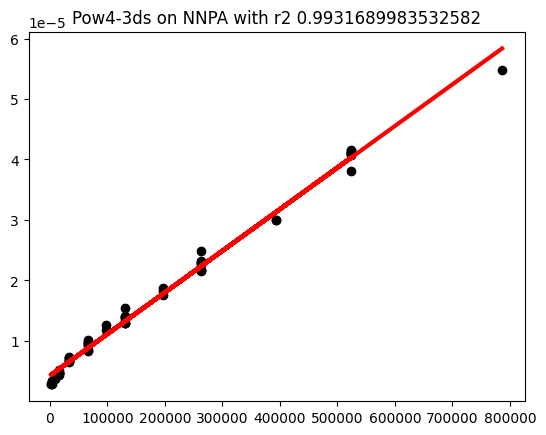

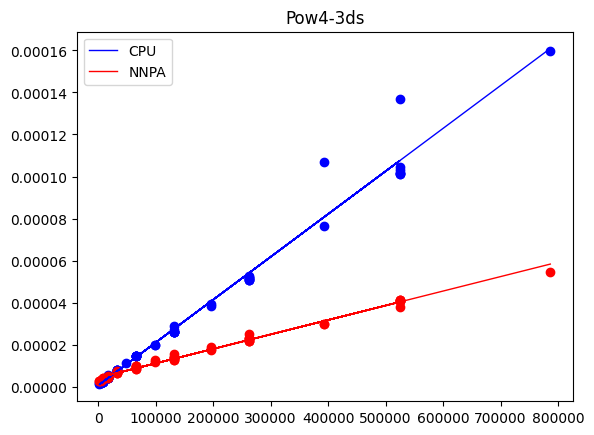

// Operation Pow4_3ds: estimated times.
double estimatedTimeForCPU_Pow4_3ds_z17(double e3, double e2, double e1) {
  double complexity = e3 * e2 * e1;
  // Regression for CPU with r2 = 0.979306482228355
  return 6.752793164225602e-07 + 2.0372887895594365e-10 * complexity;
}
// Operation Pow4_3ds: estimated times.
double estimatedTimeForNNPA_Pow4_3ds_z17(double e3, double e2, double e1) {
  double complexity  = e3 * ms_ceiling(e2, 2.0) * ms_ceiling(e1, 64.0);
  double complexity2 = e3 * ms_ceiling(e2, 32.0) * ms_ceiling(e1, 64.0);
  // Regression for NNPA with r2 = 0.9931689983532582
  return 4.268964473790506e-06 + 3.438648077067066e-11 * complexity +3.438648077067066e-11 * complexity2;
}



In [ ]:
regdb["Pow4-3ds"] = compute_reg("Pow4-3ds", dir+"test_pow-4_")

used name as prefix to load this input file /Users/alexe/OM/atests/unit-new-meas-res/res-may06-z17-all-ops-no-quant/test_pow1-8_2025-05-05-23-17-55.csv
CPU : original rows 132 , filtered rows 63
CPU : regression coef,  [[2.8617212e-10]] , intercept [1.6499106e-06] , r2,  0.9999063396503455


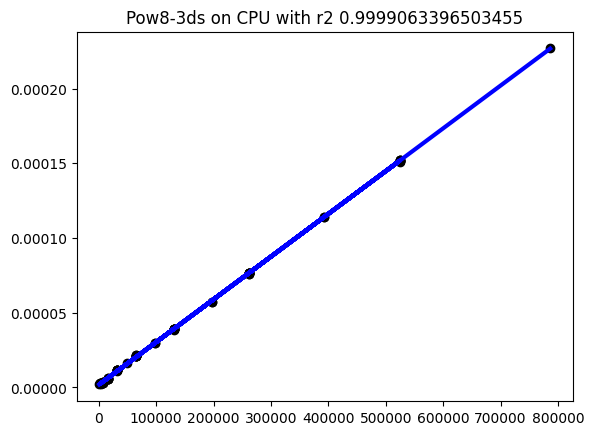

NNPA : original rows 132 , filtered rows 62
NNPA : regression coef,  [[5.19292061e-11 5.19292061e-11]] , intercept [6.14281134e-06] , r2,  0.9948502081739099


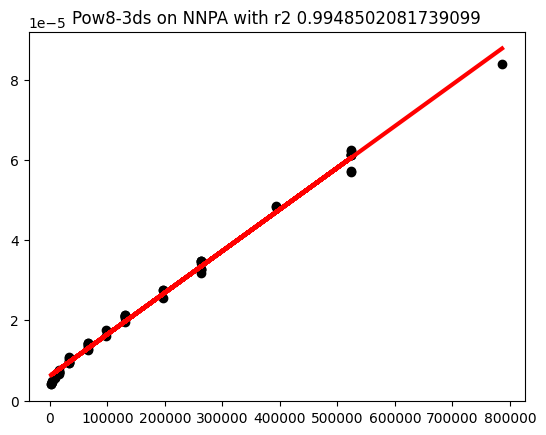

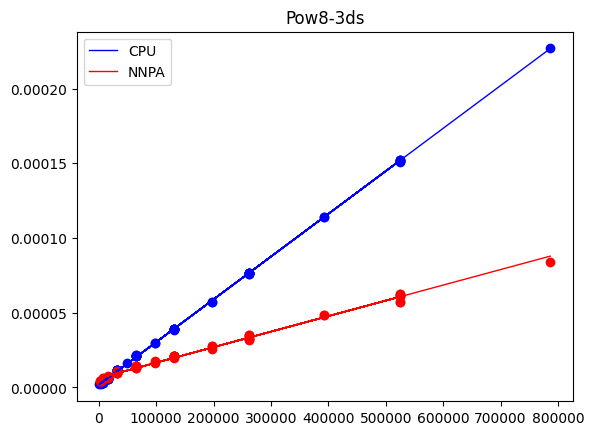

// Operation Pow8_3ds: estimated times.
double estimatedTimeForCPU_Pow8_3ds_z17(double e3, double e2, double e1) {
  double complexity = e3 * e2 * e1;
  // Regression for CPU with r2 = 0.9999063396503455
  return 1.649910604587757e-06 + 2.8617211971025847e-10 * complexity;
}
// Operation Pow8_3ds: estimated times.
double estimatedTimeForNNPA_Pow8_3ds_z17(double e3, double e2, double e1) {
  double complexity  = e3 * ms_ceiling(e2, 2.0) * ms_ceiling(e1, 64.0);
  double complexity2 = e3 * ms_ceiling(e2, 32.0) * ms_ceiling(e1, 64.0);
  // Regression for NNPA with r2 = 0.9948502081739099
  return 6.142811336589455e-06 + 5.192920606428397e-11 * complexity +5.192920606428396e-11 * complexity2;
}



In [ ]:
regdb["Pow8-3ds"] = compute_reg("Pow8-3ds", dir+"test_pow-8_")

used name as prefix to load this input file /Users/alexe/OM/atests/unit-new-meas-res/res-may06-z17-all-ops-no-quant/test_relu1_2025-05-05-22-37-20.csv
CPU : original rows 132 , filtered rows 56
CPU : regression coef,  [[9.42707329e-11]] , intercept [8.67113022e-07] , r2,  0.999247901534308


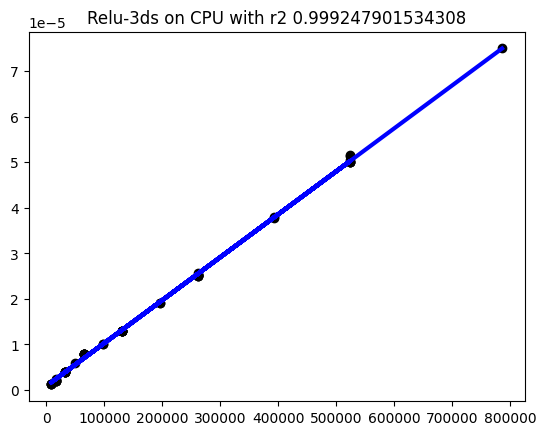

NNPA : original rows 132 , filtered rows 62
NNPA : regression coef,  [[2.31312815e-11 2.31312815e-11]] , intercept [1.98542107e-06] , r2,  0.9989466394839843


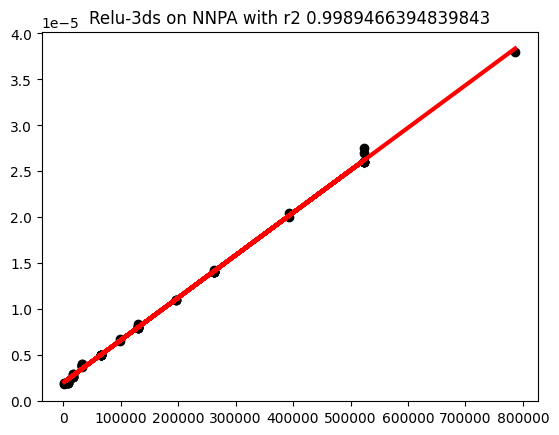

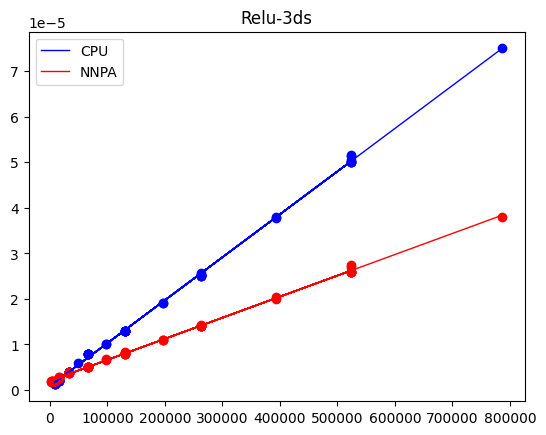

// Operation Relu_3ds: estimated times.
double estimatedTimeForCPU_Relu_3ds_z17(double e3, double e2, double e1) {
  double complexity = e3 * e2 * e1;
  // Regression for CPU with r2 = 0.999247901534308
  return 8.67113022326907e-07 + 9.427073286069188e-11 * complexity;
}
// Operation Relu_3ds: estimated times.
double estimatedTimeForNNPA_Relu_3ds_z17(double e3, double e2, double e1) {
  double complexity  = e3 * ms_ceiling(e2, 2.0) * ms_ceiling(e1, 64.0);
  double complexity2 = e3 * ms_ceiling(e2, 32.0) * ms_ceiling(e1, 64.0);
  // Regression for NNPA with r2 = 0.9989466394839843
  return 1.9854210655045904e-06 + 2.3131281524078758e-11 * complexity +2.3131281524078754e-11 * complexity2;
}



In [ ]:
regdb["Relu-3ds"] = compute_reg("Relu-3ds", dir+"test_relu_")

used name as prefix to load this input file /Users/alexe/OM/atests/unit-new-meas-res/res-may06-z17-all-ops-no-quant/test_gelu1_2025-05-05-22-39-02.csv
CPU : original rows 132 , filtered rows 63
CPU : regression coef,  [[1.10312695e-08]] , intercept [5.07659996e-06] , r2,  0.9996558252290894


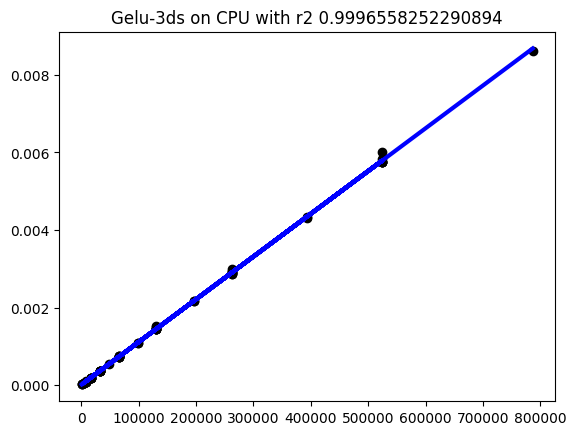

NNPA : original rows 132 , filtered rows 62
NNPA : regression coef,  [[3.57479908e-11 3.57479908e-11]] , intercept [1.76146072e-06] , r2,  0.9991600550763047


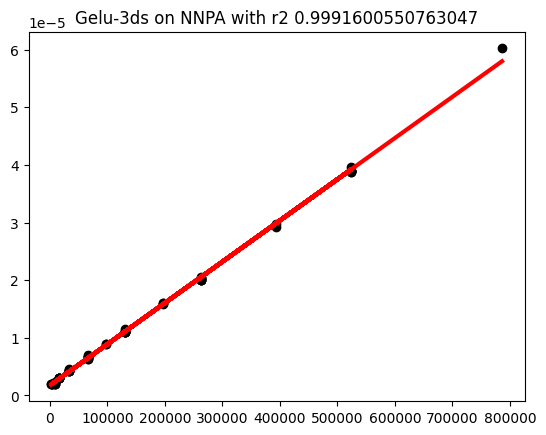

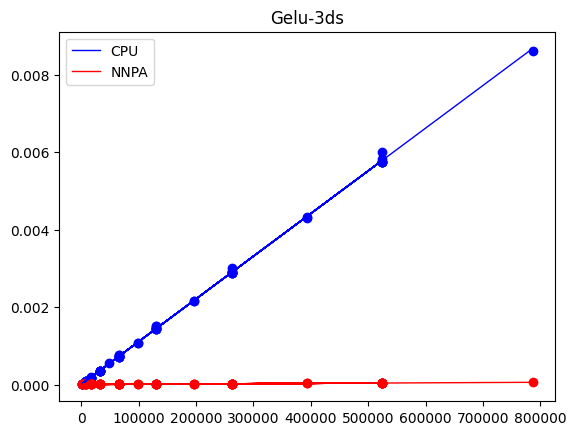

// Operation Gelu_3ds: estimated times.
double estimatedTimeForCPU_Gelu_3ds_z17(double e3, double e2, double e1) {
  double complexity = e3 * e2 * e1;
  // Regression for CPU with r2 = 0.9996558252290894
  return 5.0765999634455865e-06 + 1.10312695415442e-08 * complexity;
}
// Operation Gelu_3ds: estimated times.
double estimatedTimeForNNPA_Gelu_3ds_z17(double e3, double e2, double e1) {
  double complexity  = e3 * ms_ceiling(e2, 2.0) * ms_ceiling(e1, 64.0);
  double complexity2 = e3 * ms_ceiling(e2, 32.0) * ms_ceiling(e1, 64.0);
  // Regression for NNPA with r2 = 0.9991600550763047
  return 1.7614607196673564e-06 + 3.574799081041781e-11 * complexity +3.5747990810417806e-11 * complexity2;
}



In [ ]:
regdb["Gelu-3ds"] = compute_reg("Gelu-3ds", dir+"test_gelu_")

used name as prefix to load this input file /Users/alexe/OM/atests/unit-new-meas-res/res-may06-z17-all-ops-no-quant/test_sigmoid1_2025-05-05-22-45-36.csv
CPU : original rows 132 , filtered rows 63
CPU : regression coef,  [[1.01989571e-08]] , intercept [-0.00031106] , r2,  0.6694863546412586


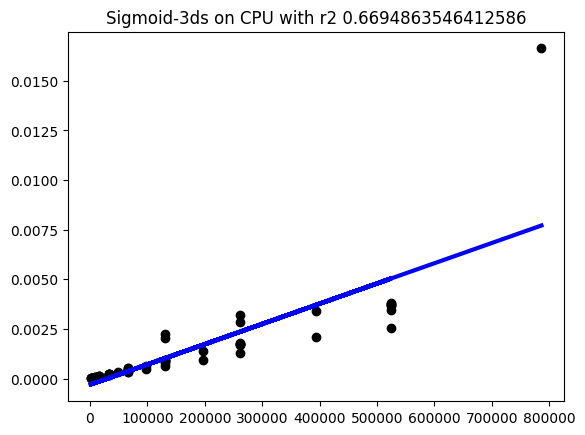

NNPA : original rows 132 , filtered rows 62
NNPA : regression coef,  [[3.76432325e-11 3.76432325e-11]] , intercept [2.26177005e-06] , r2,  0.9996518891423859


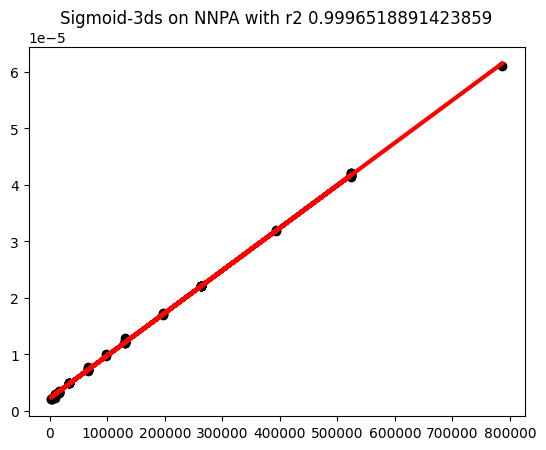

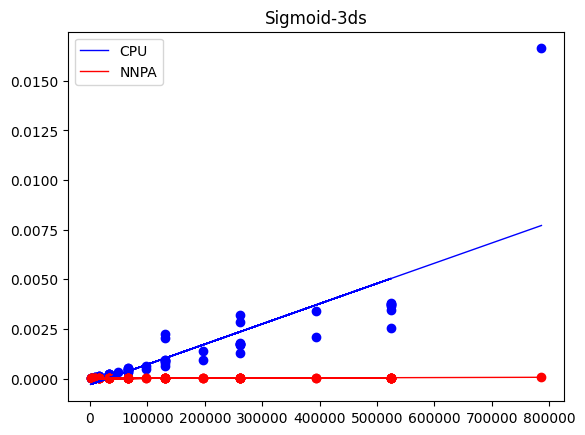

// Operation Sigmoid_3ds: estimated times.
double estimatedTimeForCPU_Sigmoid_3ds_z17(double e3, double e2, double e1) {
  double complexity = e3 * e2 * e1;
  // Regression for CPU with r2 = 0.6694863546412586
  return -0.0003110638128148975 + 1.0198957146700573e-08 * complexity;
}
// Operation Sigmoid_3ds: estimated times.
double estimatedTimeForNNPA_Sigmoid_3ds_z17(double e3, double e2, double e1) {
  double complexity  = e3 * ms_ceiling(e2, 2.0) * ms_ceiling(e1, 64.0);
  double complexity2 = e3 * ms_ceiling(e2, 32.0) * ms_ceiling(e1, 64.0);
  // Regression for NNPA with r2 = 0.9996518891423859
  return 2.261770046260627e-06 + 3.764323249035518e-11 * complexity +3.764323249035517e-11 * complexity2;
}



In [ ]:
regdb["Sigmoid-3ds"] = compute_reg("Sigmoid-3ds", dir+"test_sigmoid_")

used name as prefix to load this input file /Users/alexe/OM/atests/unit-new-meas-res/res-may06-z17-all-ops-no-quant/test_tanh1_2025-05-05-22-42-31.csv
CPU : original rows 132 , filtered rows 63
CPU : regression coef,  [[1.40785065e-09]] , intercept [3.23695989e-07] , r2,  0.9992625489601716


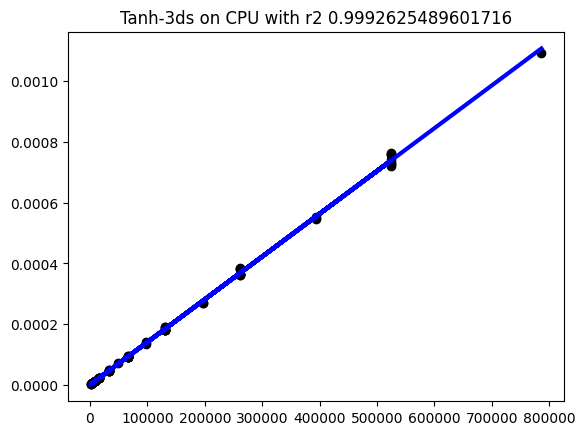

NNPA : original rows 132 , filtered rows 62
NNPA : regression coef,  [[1.79011498e-11 1.79011498e-11]] , intercept [1.97225136e-06] , r2,  0.9960934032072877


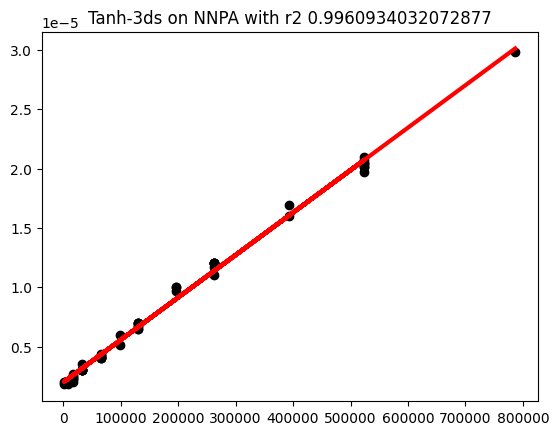

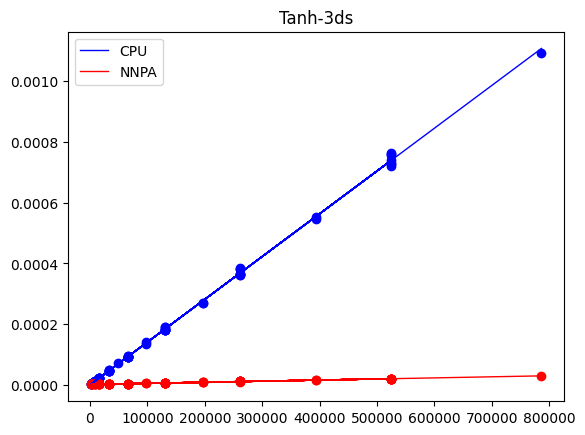

// Operation Tanh_3ds: estimated times.
double estimatedTimeForCPU_Tanh_3ds_z17(double e3, double e2, double e1) {
  double complexity = e3 * e2 * e1;
  // Regression for CPU with r2 = 0.9992625489601716
  return 3.2369598896957175e-07 + 1.4078506521178395e-09 * complexity;
}
// Operation Tanh_3ds: estimated times.
double estimatedTimeForNNPA_Tanh_3ds_z17(double e3, double e2, double e1) {
  double complexity  = e3 * ms_ceiling(e2, 2.0) * ms_ceiling(e1, 64.0);
  double complexity2 = e3 * ms_ceiling(e2, 32.0) * ms_ceiling(e1, 64.0);
  // Regression for NNPA with r2 = 0.9960934032072877
  return 1.9722513558089736e-06 + 1.790114983535808e-11 * complexity +1.7901149835358073e-11 * complexity2;
}



In [ ]:
regdb["Tanh-3ds"] = compute_reg("Tanh-3ds", dir+"test_tanh_")

used name as prefix to load this input file /Users/alexe/OM/atests/unit-new-meas-res/res-may06-z17-all-ops-no-quant/test_log1_2025-05-05-23-06-52.csv
CPU : original rows 132 , filtered rows 63
CPU : regression coef,  [[6.78344514e-09]] , intercept [-4.52973836e-05] , r2,  0.9781276143547772


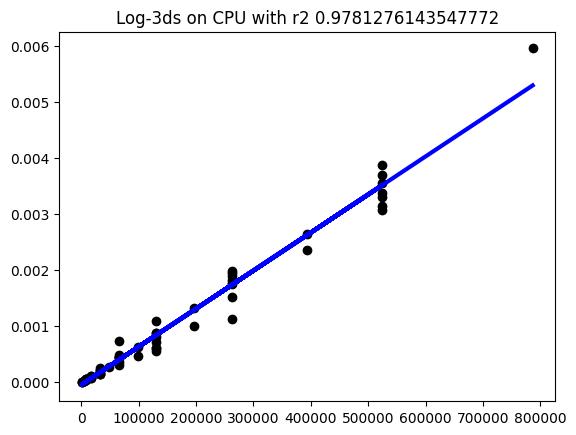

NNPA : original rows 132 , filtered rows 62
NNPA : regression coef,  [[3.11160746e-11 3.11160746e-11]] , intercept [2.05340869e-06] , r2,  0.9987930417510681


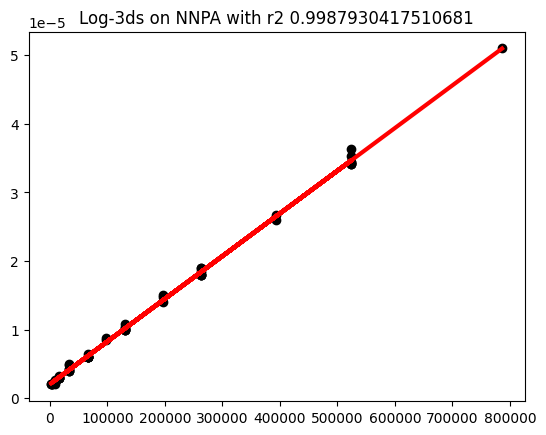

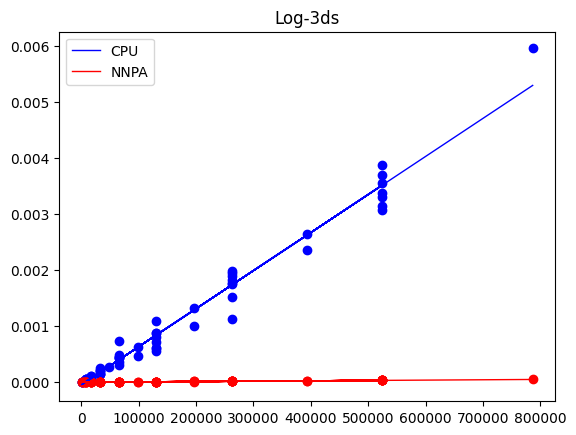

// Operation Log_3ds: estimated times.
double estimatedTimeForCPU_Log_3ds_z17(double e3, double e2, double e1) {
  double complexity = e3 * e2 * e1;
  // Regression for CPU with r2 = 0.9781276143547772
  return -4.529738358558183e-05 + 6.783445144043389e-09 * complexity;
}
// Operation Log_3ds: estimated times.
double estimatedTimeForNNPA_Log_3ds_z17(double e3, double e2, double e1) {
  double complexity  = e3 * ms_ceiling(e2, 2.0) * ms_ceiling(e1, 64.0);
  double complexity2 = e3 * ms_ceiling(e2, 32.0) * ms_ceiling(e1, 64.0);
  // Regression for NNPA with r2 = 0.9987930417510681
  return 2.0534086916963085e-06 + 3.111607458075494e-11 * complexity +3.111607458075493e-11 * complexity2;
}



In [ ]:
regdb["Log-3ds"] = compute_reg("Log-3ds", dir+"test_log_")

used name as prefix to load this input file /Users/alexe/OM/atests/unit-new-meas-res/res-may06-z17-all-ops-no-quant/test_exp1_2025-05-05-23-00-40.csv
CPU : original rows 132 , filtered rows 63
CPU : regression coef,  [[6.21757e-09]] , intercept [-5.18017981e-05] , r2,  0.89242570724948


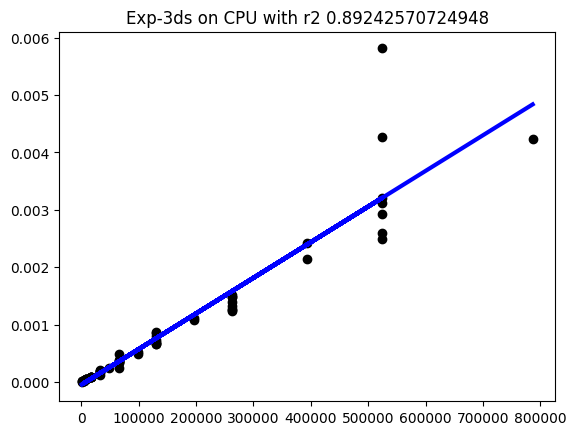

NNPA : original rows 132 , filtered rows 62
NNPA : regression coef,  [[2.61825345e-11 2.61825345e-11]] , intercept [2.08559369e-06] , r2,  0.999015162322293


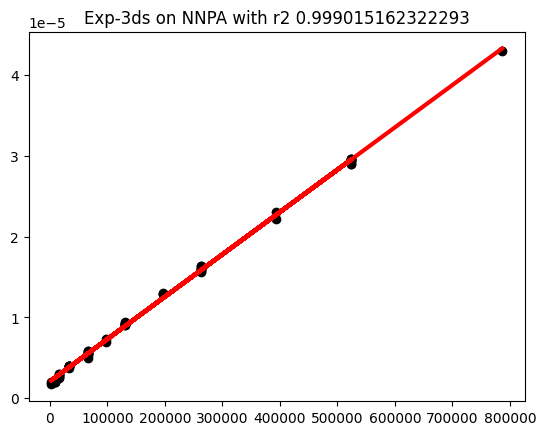

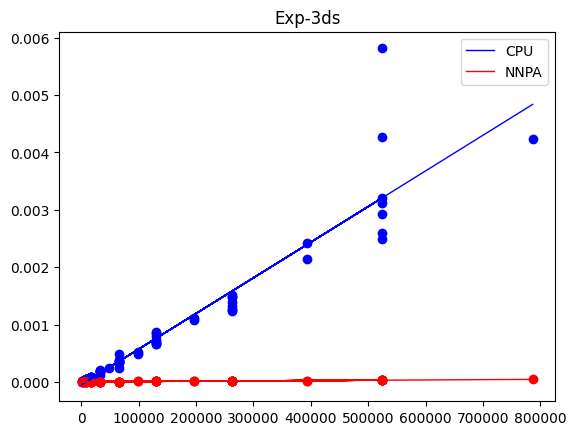

// Operation Exp_3ds: estimated times.
double estimatedTimeForCPU_Exp_3ds_z17(double e3, double e2, double e1) {
  double complexity = e3 * e2 * e1;
  // Regression for CPU with r2 = 0.89242570724948
  return -5.1801798144228634e-05 + 6.21757000288656e-09 * complexity;
}
// Operation Exp_3ds: estimated times.
double estimatedTimeForNNPA_Exp_3ds_z17(double e3, double e2, double e1) {
  double complexity  = e3 * ms_ceiling(e2, 2.0) * ms_ceiling(e1, 64.0);
  double complexity2 = e3 * ms_ceiling(e2, 32.0) * ms_ceiling(e1, 64.0);
  // Regression for NNPA with r2 = 0.999015162322293
  return 2.085593685056712e-06 + 2.6182534527148465e-11 * complexity +2.6182534527148458e-11 * complexity2;
}



In [ ]:
regdb["Exp-3ds"] = compute_reg("Exp-3ds", dir+"test_exp_")

used name as prefix to load this input file /Users/alexe/OM/atests/unit-new-meas-res/res-may06-z17-all-ops-no-quant/test_softmax1_2025-05-05-22-52-30.csv
CPU : original rows 132 , filtered rows 45
CPU : regression coef,  [[7.89522274e-09]] , intercept [4.92212435e-06] , r2,  0.9941480124435297


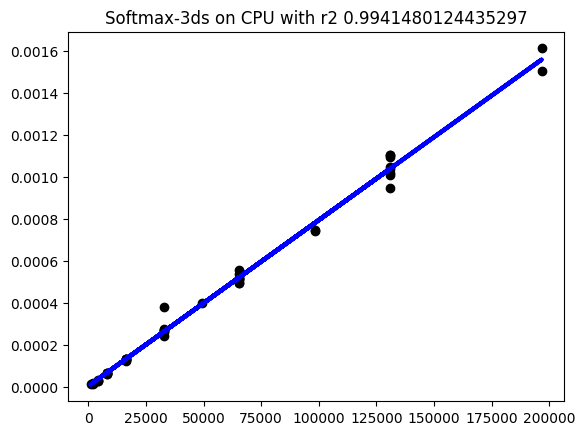

NNPA : original rows 132 , filtered rows 43
NNPA : regression coef,  [[9.54689746e-10 9.54689746e-10]] , intercept [-1.65829513e-06] , r2,  0.7698271519020907


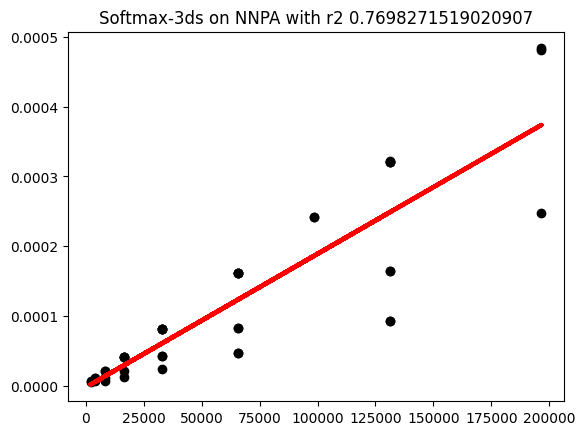

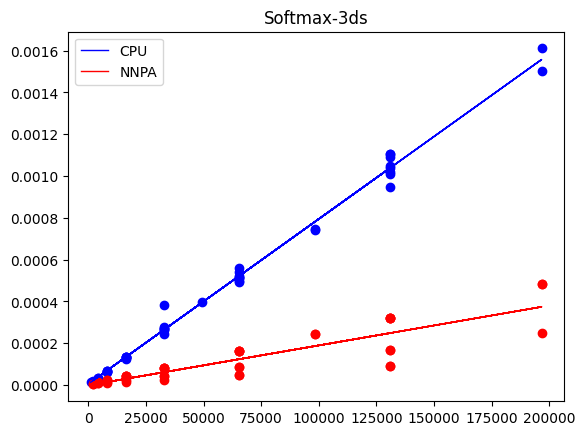

// Operation Softmax_3ds: estimated times.
double estimatedTimeForCPU_Softmax_3ds_z17(double e3, double e2, double e1) {
  double complexity = e3 * e2 * e1;
  // Regression for CPU with r2 = 0.9941480124435297
  return 4.922124351942512e-06 + 7.895222736377622e-09 * complexity;
}
// Operation Softmax_3ds: estimated times.
double estimatedTimeForNNPA_Softmax_3ds_z17(double e3, double e2, double e1) {
  double complexity  = e3 * ms_ceiling(e2, 2.0) * ms_ceiling(e1, 64.0);
  double complexity2 = e3 * ms_ceiling(e2, 32.0) * ms_ceiling(e1, 64.0);
  // Regression for NNPA with r2 = 0.7698271519020907
  return -1.6582951337863099e-06 + 9.546897460120308e-10 * complexity +9.546897460120308e-10 * complexity2;
}



In [ ]:
regdb["Softmax-3ds"] = compute_reg("Softmax-3ds", dir+"test_softmax_", max_compute=2e5, print_graph=2)

used name as prefix to load this input file /Users/alexe/OM/atests/unit-new-meas-res/res-may06-z17-all-ops-no-quant/test_reducemean1_2025-05-05-23-19-46.csv
CPU : original rows 132 , filtered rows 57
CPU : regression coef,  [[1.27151265e-10]] , intercept [-3.44566942e-08] , r2,  0.9641896473441319


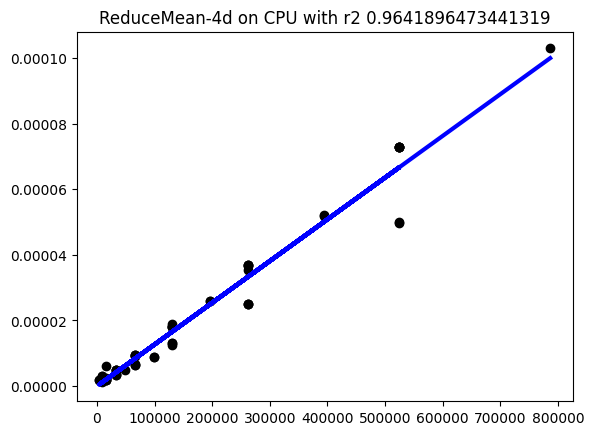

NNPA : original rows 132 , filtered rows 62
NNPA : regression coef,  [[9.61079143e-12 9.61079143e-12]] , intercept [1.13023002e-05] , r2,  0.23925537331066915


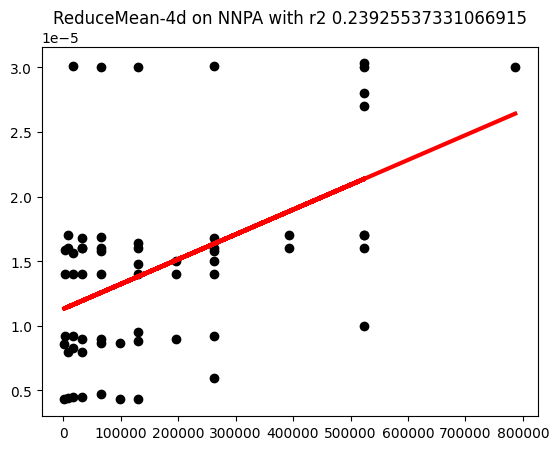

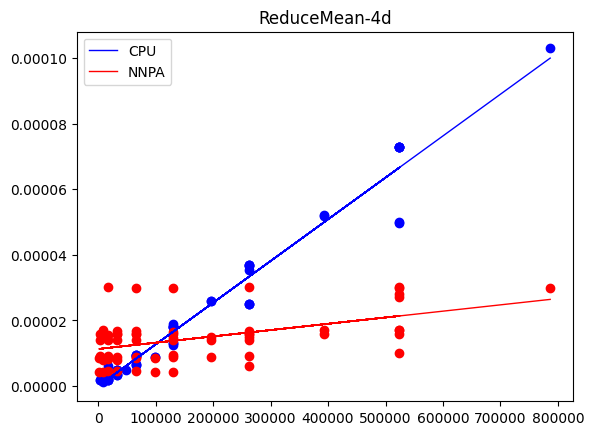

// Operation ReduceMean_4d: estimated times.
double estimatedTimeForCPU_ReduceMean_4d_z17(double e3, double e2, double e1) {
  double complexity = e3 * e2 * e1;
  // Regression for CPU with r2 = 0.9641896473441319
  return -3.44566941822172e-08 + 1.2715126545232464e-10 * complexity;
}
// Operation ReduceMean_4d: estimated times.
double estimatedTimeForNNPA_ReduceMean_4d_z17(double e3, double e2, double e1) {
  double complexity  = e3 * ms_ceiling(e2, 2.0) * ms_ceiling(e1, 64.0);
  double complexity2 = e3 * ms_ceiling(e2, 32.0) * ms_ceiling(e1, 64.0);
  // Regression for NNPA with r2 = 0.23925537331066915
  return 1.130230016902706e-05 + 9.610791426943572e-12 * complexity +9.610791426943571e-12 * complexity2;
}



In [ ]:
regdb["ReduceMean-4d"] = compute_reg("ReduceMean-4d", dir+"test_reducemean_")

used name as prefix to load this input file /Users/alexe/OM/atests/unit-new-meas-res/res-may06-z17-all-ops-no-quant/test_stick1_2025-05-06-11-08-40.csv
CPU : original rows 132 , filtered rows 40
CPU : regression coef,  [[1.36969993e-10]] , intercept [7.87266052e-07] , r2,  0.9860676916174972


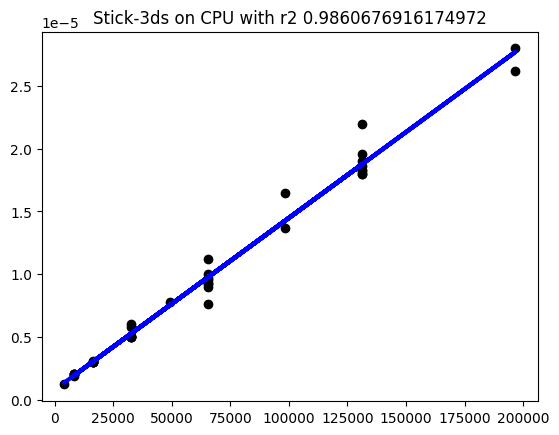

NNPA : original rows 132 , filtered rows 43
NNPA : regression coef,  [[1.96773284e-10 1.96773284e-10]] , intercept [3.61409806e-06] , r2,  0.5293178772932285


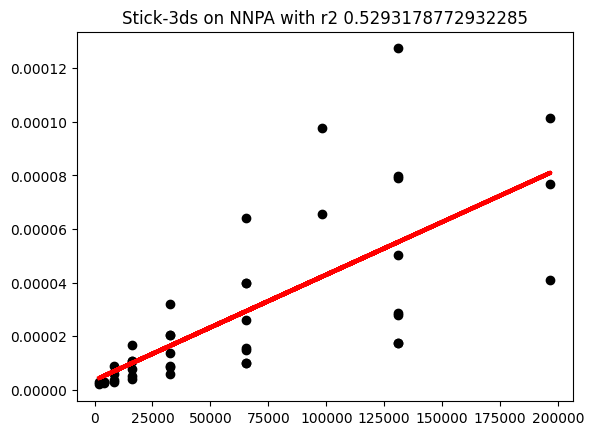

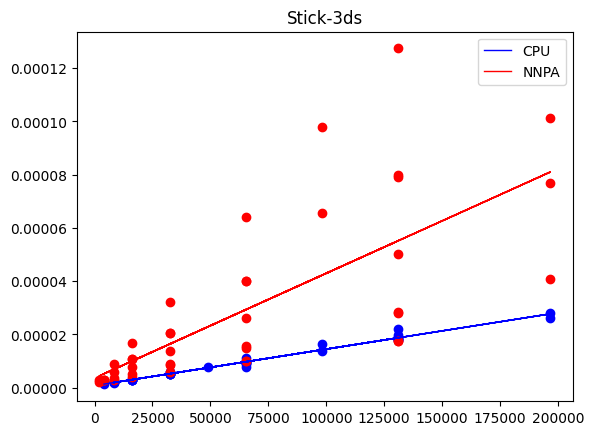

// Operation Stick_3ds: estimated times.
double estimatedTimeForCPU_Stick_3ds_z17(double e3, double e2, double e1) {
  double complexity = e3 * e2 * e1;
  // Regression for CPU with r2 = 0.9860676916174972
  return 7.872660520579271e-07 + 1.3696999349900444e-10 * complexity;
}
// Operation Stick_3ds: estimated times.
double estimatedTimeForNNPA_Stick_3ds_z17(double e3, double e2, double e1) {
  double complexity  = e3 * ms_ceiling(e2, 2.0) * ms_ceiling(e1, 64.0);
  double complexity2 = e3 * ms_ceiling(e2, 32.0) * ms_ceiling(e1, 64.0);
  // Regression for NNPA with r2 = 0.5293178772932285
  return 3.6140980638410674e-06 + 1.9677328386223787e-10 * complexity +1.9677328386223787e-10 * complexity2;
}



In [ ]:
regdb["Stick-3ds"] = compute_reg("Stick-3ds", dir+"test_stick_", max_compute=2e5)

used name as prefix to load this input file /Users/alexe/OM/atests/unit-new-meas-res/res-may06-z17-all-ops-no-quant/test_stick1_2025-05-06-11-08-40.csv
CPU : original rows 132 , filtered rows 58
CPU : regression coef,  [[1.38938201e-10]] , intercept [7.65393422e-07] , r2,  0.9932274704371545


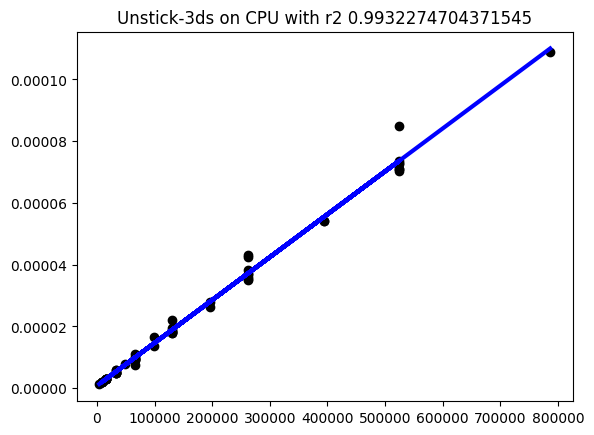

NNPA : original rows 132 , filtered rows 62
NNPA : regression coef,  [[1.56935131e-10 1.56935131e-10]] , intercept [1.0784429e-05] , r2,  0.4294645871109005


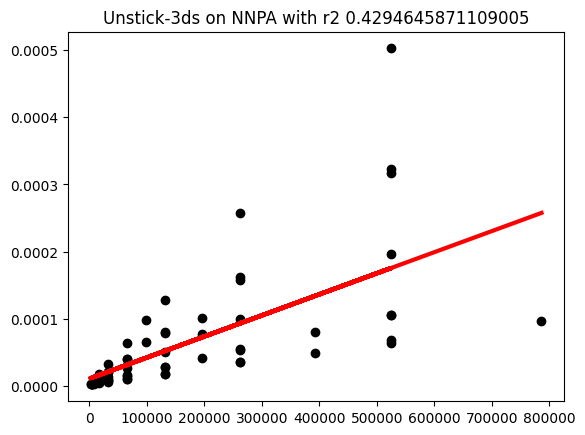

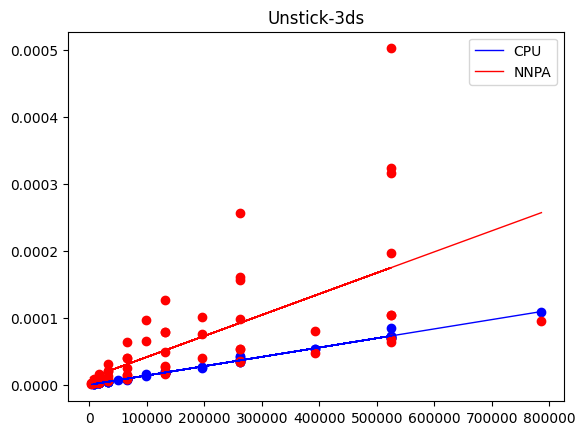

// Operation Unstick_3ds: estimated times.
double estimatedTimeForCPU_Unstick_3ds_z17(double e3, double e2, double e1) {
  double complexity = e3 * e2 * e1;
  // Regression for CPU with r2 = 0.9932274704371545
  return 7.653934223015085e-07 + 1.389382010359011e-10 * complexity;
}
// Operation Unstick_3ds: estimated times.
double estimatedTimeForNNPA_Unstick_3ds_z17(double e3, double e2, double e1) {
  double complexity  = e3 * ms_ceiling(e2, 2.0) * ms_ceiling(e1, 64.0);
  double complexity2 = e3 * ms_ceiling(e2, 32.0) * ms_ceiling(e1, 64.0);
  // Regression for NNPA with r2 = 0.4294645871109005
  return 1.0784429022719318e-05 + 1.569351314487559e-10 * complexity +1.5693513144875584e-10 * complexity2;
}



In [ ]:
regdb["Unstick-3ds"] = compute_reg("Unstick-3ds", dir+"test_stick_")
#plot_regressions(regdb, (("Stick-3ds","nnpa"),("Unstick-3ds","nnpa")))


used name as prefix to load this input file /Users/alexe/OM/atests/unit-new-meas-res/res-may06-z17-all-ops-no-quant/test_matmul1_3d_2025-05-05-23-23-24.csv
CPU: Use MatMul 3D compute complexity.
CPU : original rows 90 , filtered rows 45
CPU : regression coef,  [[5.05065095e-11]] , intercept [1.8552228e-06] , r2,  0.9884079270433619


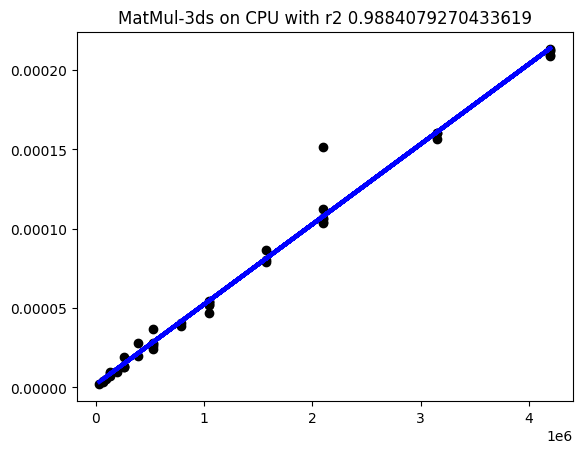

NNPA: Use MatMul 3D compute complexity.
NNPA : original rows 90 , filtered rows 40
NNPA : regression coef,  [[8.90586507e-13 8.90586507e-13]] , intercept [1.82595709e-06] , r2,  0.7060733589527228


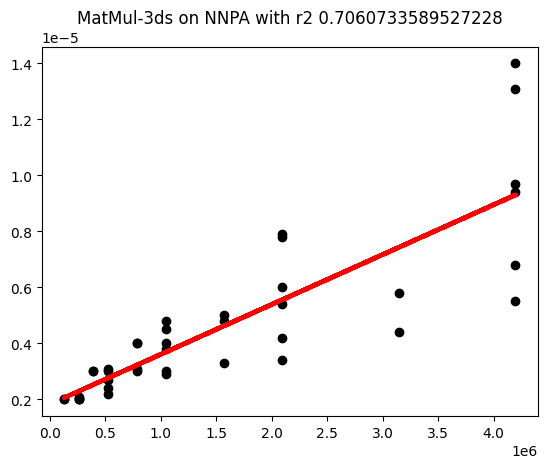

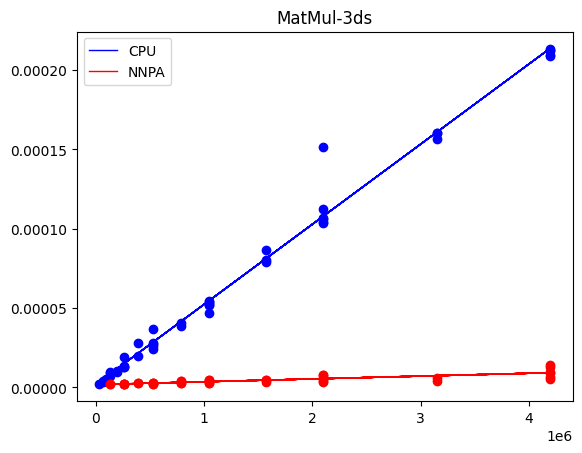

// Operation MatMul_3ds: estimated times.
double estimatedTimeForCPU_MatMul_3ds_z17(double B, double N, double M, double K) {
  double complexity = B * (N * M * K);
  // Regression for CPU with r2 = 0.9884079270433619
  return 1.855222799861678e-06 + 5.050650951084619e-11 * complexity;
}
// Operation MatMul_3ds: estimated times.
double estimatedTimeForNNPA_MatMul_3ds_z17(double B, double N, double M, double K) {
  double complexity  = B * ms_ceiling(N, 2.0) * ms_ceiling(M, 64.0) * ms_ceiling(K, 64.0);
  double complexity2 = B * ms_ceiling(N, 32.0) * ms_ceiling(M, 64.0) * ms_ceiling(K, 64.0);
  // Regression for NNPA with r2 = 0.7060733589527228
  return 1.8259570877531345e-06 + 8.905865072399348e-13 * complexity +8.905865072399348e-13 * complexity2;
}



In [ ]:
regdb["MatMul-3ds"] = compute_reg("MatMul-3ds", dir+"test_matmul_3d_", max_compute=5e6, min_e2=32, min_e1=32)

used name as prefix to load this input file /Users/alexe/OM/atests/unit-new-meas-res/res-may06-z17-all-ops-no-quant/test_matmul1_bcast23_2025-05-05-23-24-33.csv
CPU: Use MatMul 3D compute complexity.
CPU : original rows 90 , filtered rows 45
CPU : regression coef,  [[4.95090674e-11]] , intercept [1.20185407e-07] , r2,  0.999572142279475


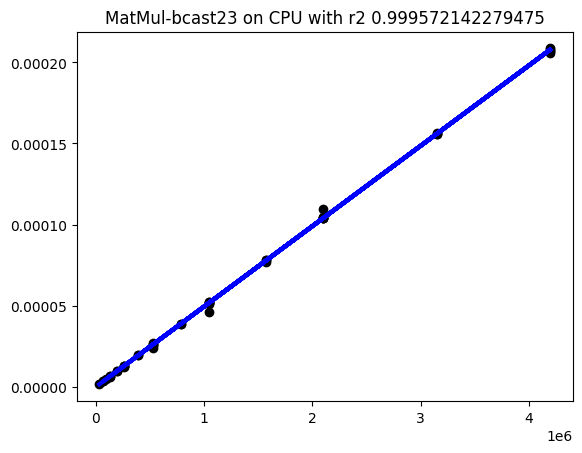

NNPA: Use MatMul 3D compute complexity.
NNPA : original rows 90 , filtered rows 40
NNPA : regression coef,  [[6.11565497e-13 6.11565497e-13]] , intercept [2.18618129e-06] , r2,  0.8552465991036068


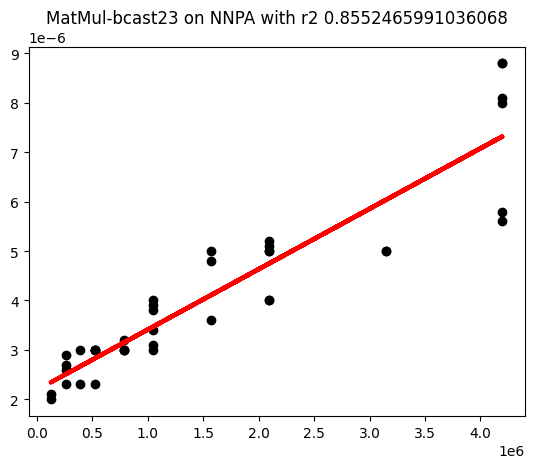

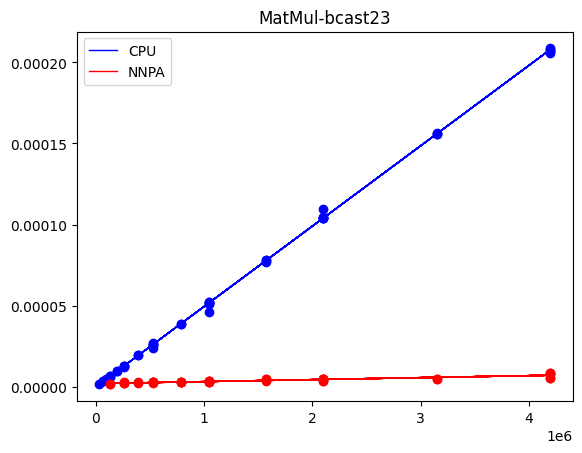

// Operation MatMul_bcast23: estimated times.
double estimatedTimeForCPU_MatMul_bcast23_z17(double B, double N, double M, double K) {
  double complexity = B * (N * M * K);
  // Regression for CPU with r2 = 0.999572142279475
  return 1.2018540664406345e-07 + 4.950906739952868e-11 * complexity;
}
// Operation MatMul_bcast23: estimated times.
double estimatedTimeForNNPA_MatMul_bcast23_z17(double B, double N, double M, double K) {
  double complexity  = B * ms_ceiling(N, 2.0) * ms_ceiling(M, 64.0) * ms_ceiling(K, 64.0);
  double complexity2 = B * ms_ceiling(N, 32.0) * ms_ceiling(M, 64.0) * ms_ceiling(K, 64.0);
  // Regression for NNPA with r2 = 0.8552465991036068
  return 2.1861812921890076e-06 + 6.115654970204012e-13 * complexity +6.115654970204012e-13 * complexity2;
}



In [ ]:
regdb["MatMul-bcast23"] = compute_reg("MatMul-bcast23", dir+"test_matmul_bcast23_", max_compute=5e6, min_e2=32, min_e1=32)

In [ ]:
print("""
/*
 * SPDX-License-Identifier: Apache-2.0
 */

//===----------------- Auto-Generated, do not change  ---------------------===//
//
// Copyright 2025 The IBM Research Authors.
// Generated by the utils/nnpa-op-perf-model/generateModel.ipynb
// See Readme in that directory for more info.
//
// =============================================================================

inline static double ms_ceiling(double n, double m) { return ceil(n / m) * m; }

""")
      
for op in sorted(regdb):
    print(regdb[op]["code"])


/*
 * SPDX-License-Identifier: Apache-2.0
 */

//===----------------- Auto-Generated, do not change  ---------------------===//
//
// Copyright 2025 The IBM Research Authors.
//
// =============================================================================

inline static double ms_ceiling(double n, double m) { return ceil(n / m) * m; }


// Operation Add_3ds: estimated times.
double estimatedTimeForCPU_Add_3ds_z17(double e3, double e2, double e1) {
  double complexity = e3 * e2 * e1;
  // Regression for CPU with r2 = 0.9794305300045331
  return 1.0414597616987286e-06 + 9.436133475545827e-11 * complexity;
}
// Operation Add_3ds: estimated times.
double estimatedTimeForNNPA_Add_3ds_z17(double e3, double e2, double e1) {
  double complexity  = e3 * ms_ceiling(e2, 2.0) * ms_ceiling(e1, 64.0);
  double complexity2 = e3 * ms_ceiling(e2, 32.0) * ms_ceiling(e1, 64.0);
  // Regression for NNPA with r2 = 0.9697580789334318
  return 1.8567493018624777e-06 + 1.9088979028012123e-11 * complexity 